In [1]:
# 8월 6일 일요일 12시까지
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
# from sklearn.tree import export_graphviz
# import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
# 데이터 구성:Series, DataFrame
import pandas as pd
# 행렬 연산
import numpy as np
# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib
# scaling
from sklearn.preprocessing import StandardScaler
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 로지스틱 회귀
from statsmodels.api import Logit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

from scipy.stats import f_oneway

from sklearn.metrics import r2_score
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline
matplotlib.rc('font',family = 'Noto Sans CJK JP')
matplotlib.rc('axes',unicode_minus = False)

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

# matplotlib.rc('font',family='Malgun Gothic')
matplotlib.rc('font',family='Noto Sans CJK JP')
matplotlib.rc('axes',unicode_minus=False)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

In [3]:
df_raw=pd.read_csv('/home/piai/다운로드/7_Path.csv')
df_raw.head()

,No_Die,Lot_Num,Wafer_Num,Ox_Chamber,photo_soft_Chamber,lithography_Chamber,Etching_Chamber,Chamber_Num,Error_message,Error,Short_Path,Path,Target,Datetime
0,NOLSM325131325,13,28,2,1,1,1,1,none,1,2111,21111,141,01-03-2022
1,NOLSM326132326,13,29,2,1,1,2,2,none,1,2112,21122,55,01-03-2022
2,NOLSM327133327,13,30,2,1,1,3,3,none,1,2113,21133,96,01-03-2022
3,NOLSM328134328,13,31,2,1,1,1,1,none,1,2111,21111,105,01-03-2022
4,NOLSM329135329,13,32,2,1,1,2,2,none,1,2112,21122,79,01-03-2022


In [4]:
df_raw["Datetime"] = pd.to_datetime(df_raw["Datetime"], format="%d-%m-%Y")
df_raw = df_raw.drop(df_raw.index[-1])

In [5]:
df_raw['index'] = df_raw.index
df_raw.sort_values(by="Path", inplace=True)
df_raw.head()

,No_Die,Lot_Num,Wafer_Num,Ox_Chamber,photo_soft_Chamber,lithography_Chamber,Etching_Chamber,Chamber_Num,Error_message,Error,Short_Path,Path,Target,Datetime,index
27,NOLSM326132,13,2,1,1,1,1,1,none,1,1111,11111,55,2022-03-01,27
927,NOLSM124516,5,16,1,1,1,1,1,none,1,1111,11111,94,2022-02-21,927
1213,NOLSM736287736,28,34,1,1,1,1,1,none,1,1111,11111,123,2022-02-24,1213
435,NOLSM7177,1,34,1,1,1,1,1,none,1,1111,11111,97,2022-02-17,435
1592,NOLSM8233113,31,13,1,1,1,1,1,none,1,1111,11111,45,2022-02-27,1592


In [53]:
# Mini_Path를 기준으로 데이터 그룹화
grouped = df_raw.groupby("Path")

# Mini_Path 리스트 생성
real_paths = df_raw["Path"].unique()

# 큰 편차 저장 리스트
max_deviation_values = []
# 작은 편차 리스트
min_deviation_values = []
# 안정, 불안정 카운트 리스트
status_counts = []

# Mini_Path별로 차트 그리기
for real_path in real_paths:
    group = grouped.get_group(real_path)

    c_chart_data = group["Target"]
    timestamps = group["index"]
    error_data = group["Error"]

    num_data_points = len(c_chart_data)
    # if num_data_points <= 10:  # 데이터 갯수가 10 이하인 경우 처리하지 않음
    #     continue

    mean = c_chart_data.mean()
    UCL = mean + (3 * np.sqrt(mean))
    LCL = mean - (3 * np.sqrt(mean))

    deviations = np.abs(c_chart_data - mean)
    max_deviations = deviations.nlargest(5)  # 가장 큰 5개의 편차 값을 구합니다.
    # max_deviation_values.append({real_path: max_deviations.tolist()})
    max_deviation_targets = group.loc[max_deviations.index, "Target"]  # 가장 큰 편차 값의 Target을 가져옵니다.
    max_deviation_values.append({real_path: max_deviation_targets.tolist()})

    deviations = np.abs(c_chart_data - mean)
    min_deviations = deviations.nsmallest(5)  # 가장 큰 5개의 편차 값을 구합니다.
    # min_deviation_values.append({real_path: min_deviations.tolist()})
    min_deviation_targets = group.loc[min_deviations.index, "Target"]  # 가장 작은 편차 값의 Target을 가져옵니다.
    min_deviation_values.append({real_path: min_deviation_targets.tolist()})

    stability_count = 0
    instability_count = 0
    error_count = 0
    deviations_squared = (c_chart_data - mean) ** 2
    variance = deviations_squared.mean()

    for value in c_chart_data:
        if LCL <= value <= UCL:
            stability_count += 1
        else:
            instability_count += 1

    for ed in error_data:
        if ed==0:
            error_count += 1
    status_counts.append({real_path: {"stability": stability_count, "instability": instability_count, "defective":error_count, "variance": variance}})


In [31]:
# 새로운 데이터 형식으로 변환
max_deviation_data_list = []
for item in max_deviation_values:
    for path, worst_values in item.items():
        new_item = {"path": path}
        for i, worst_value in enumerate(worst_values, start=1):
            new_item[f"worst{i}"] = worst_value
        max_deviation_data_list.append(new_item)

# DataFrame 생성
max_deviation_data_df = pd.DataFrame(max_deviation_data_list)
max_deviation_data_df["path"] = max_deviation_data_df["path"].astype(int)

# 결과 출력
max_deviation_data_df.head()

,path,worst1,worst2,worst3,worst4,worst5
0,11111,204,148,39,146,45
1,11122,156,15,143,24,27
2,11133,229,201,192,180,15
3,11211,230,216,48,54,72
4,11222,216,207,9,15,171


In [32]:
# 새로운 데이터 형식으로 변환
min_deviation_data_list = []
for item in min_deviation_values:
    for path, worst_values in item.items():
        new_item = {"path": path}
        for i, worst_value in enumerate(worst_values, start=1):
            new_item[f"best{i}"] = worst_value
        min_deviation_data_list.append(new_item)

# DataFrame 생성
min_deviation_data_df = pd.DataFrame(min_deviation_data_list)
min_deviation_data_df["path"] = min_deviation_data_df["path"].astype(int)

# 결과 출력
min_deviation_data_df.head()

,path,best1,best2,best3,best4,best5
0,11111,93,94,96,97,97
1,11122,75,92,99,102,102
2,11133,96,95,94,100,92
3,11211,117,124,102,138,96
4,11222,96,96,96,91,99


In [46]:
# 데이터 리스트에서 딕셔너리 키와 값 추출
real_path = [list(item.keys())[0] for item in status_counts]
stabilities = [list(item.values())[0]['stability'] for item in status_counts]
instabilities = [list(item.values())[0]['instability'] for item in status_counts]
instabilities_rate = [list(item.values())[0]['instability']/(list(item.values())[0]['instability']+list(item.values())[0]['stability']) for item in status_counts]
defective_count = [list(item.values())[0]['defective'] for item in status_counts]
variance_count = [list(item.values())[0]['variance'] for item in status_counts]

# DataFrame 생성
status_counts_data_df = pd.DataFrame({
    'real_path': real_path,
    'stability': stabilities,
    'instability': instabilities,
    'instabilities_rate': instabilities_rate,
    'defective_count': defective_count,
    'variance': variance_count
})

status_counts_data_df.head()

,real_path,stability,instability,instabilities_rate,defective_count,variance
0,11111,16,13,0.448276,1,1368.784780
1,11122,6,6,0.500000,0,1916.388889
2,11133,16,14,0.466667,2,2648.538889
3,11211,6,6,0.500000,2,3038.243056
4,11222,24,17,0.414634,2,2154.141582


In [34]:
status_counts_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   real_path           64 non-null     int64  
 1   stability           64 non-null     int64  
 2   instability         64 non-null     int64  
 3   instabilities_rate  64 non-null     float64
 4   defective_count     64 non-null     int64  
 5   variance            64 non-null     float64
dtypes: float64(2), int64(4)
memory usage: 3.1 KB


In [35]:
status_counts_data_df.sort_values(by="variance", inplace=True)
status_counts_data_df.head(10)

,real_path,stability,instability,instabilities_rate,defective_count,variance
7,11322,6,6,0.500000,0,932.472222
47,23311,14,12,0.461538,0,1075.321006
14,12233,8,4,0.333333,0,1154.909722
61,33222,24,10,0.294118,1,1221.547578
0,11111,16,13,0.448276,1,1368.784780
53,31333,15,11,0.423077,0,1560.023669
21,13211,8,4,0.333333,0,1581.500000
48,23333,17,9,0.346154,1,1690.610947
29,21133,15,14,0.482759,0,1726.206897
60,33133,13,13,0.500000,0,1757.178994


In [36]:
status_counts_data_df.tail(10)

,real_path,stability,instability,instabilities_rate,defective_count,variance
22,13222,20,22,0.523810,2,6086.376984
38,22133,7,17,0.708333,5,6708.638889
20,13133,6,16,0.727273,3,6846.845041
17,12333,10,19,0.655172,5,6927.338882
24,13311,15,13,0.464286,1,7100.401786
5,11233,8,4,0.333333,2,7495.722222
10,12122,5,7,0.583333,1,7670.472222
49,31111,11,15,0.576923,4,7758.226331
50,31133,8,17,0.680000,4,8273.840000
58,32333,7,11,0.611111,3,9179.608025


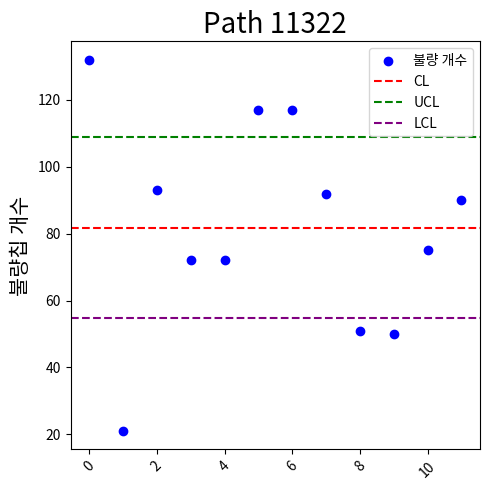

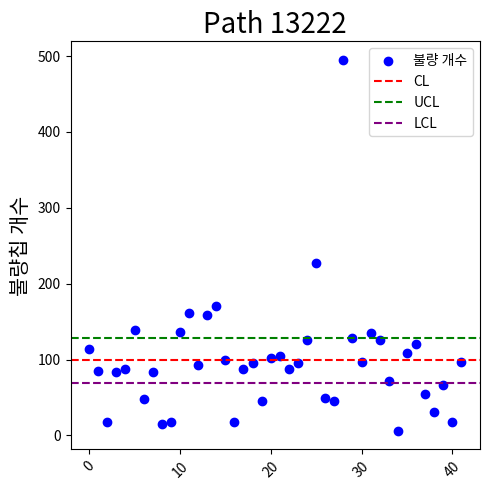

In [61]:
# Mini_Path를 기준으로 데이터 그룹화
grouped = df_raw.groupby("Path")

# Mini_Path 리스트 생성
paths = df_raw["Path"].unique()

# Mini_Path별로 차트 그리기
for path in [11322,13222]:
    # group = df_raw[df_raw["Mini_Path"] == mini_path] 이거 교수님 코드
    # group.reset_index(drop = True, inplace = True) 이거 교수님 코드
    group = grouped.get_group(path)
    group.reset_index(drop = True, inplace = True)
    
    c_chart_data = group["Target"]
    timestamps = group.index
    error_data = group["Error"]

    num_data_points = len(c_chart_data)
    if num_data_points <= 10:  # 데이터 갯수가 10 이하인 경우 처리하지 않음
        continue

    mean = c_chart_data.mean()
    UCL = mean + (3 * np.sqrt(mean))
    LCL = mean - (3 * np.sqrt(mean))

    plt.figure(figsize=(5, 5))
    plt.scatter(timestamps, c_chart_data, marker='o', color='blue', label='불량 개수')  # timestamps를 그대로 사용
    plt.axhline(mean, color='red', linestyle='dashed', label='CL')
    plt.axhline(UCL, color='green', linestyle='dashed', label='UCL')
    plt.axhline(LCL, color='purple', linestyle='dashed', label='LCL')
    # plt.ylim(0, 500)
    plt.title(f"Path {int(path)}", fontsize=20)
    # plt.xlabel('날짜')
    plt.ylabel('불량칩 개수', fontsize=15)
    plt.legend()
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()

    plt.show()


안정: 11322<br>불안정: 13222

In [22]:
count_11322 = len(df_raw.loc[(df_raw["Path"] == 11322) & (df_raw["Error"] == 0)])
count_13222 = len(df_raw.loc[(df_raw["Path"] == 13222) & (df_raw["Error"] == 0)])

print("Path 11322의 불량품 갯수:", count_11322)
print("Path 13222의 불량품 갯수:", count_13222)
print("Path 11322의 전체 웨이퍼 갯수:", len(df_raw.loc[df_raw["Path"] == 11322]))
print("Path 13222의 전체 웨이퍼 갯수:", len(df_raw.loc[df_raw["Path"] == 13222]))


Path 11322의 불량품 갯수: 0
Path 13222의 불량품 갯수: 2
Path 11322의 전체 웨이퍼 갯수: 12
Path 13222의 전체 웨이퍼 갯수: 42


In [23]:
target_sum_11322 = df_raw[df_raw['Path'] == 11322]['Target'].sum()
target_sum_error_0_11322 = df_raw[(df_raw['Path'] == 11322) & (df_raw['Error'] == 0)]['Target'].sum()
target_sum_13222 = df_raw[df_raw['Path'] == 13222]['Target'].sum()
target_sum_error_0_13222 = df_raw[(df_raw['Path'] == 13222) & (df_raw['Error'] == 0)]['Target'].sum()

print("안정 Path가 11322인 Target의 합:", target_sum_11322)
print("안정 Path가 11322인 Error가 0인 Target의 합:", target_sum_error_0_11322)
print("불안정 Path가 13222인 Target의 합:", target_sum_13222)
print("불안정 Path가 13222인 Error가 0인 Target의 합:", target_sum_error_0_13222)

안정 Path가 11322인 Target의 합: 982
안정 Path가 11322인 Error가 0인 Target의 합: 0
불안정 Path가 13222인 Target의 합: 4151
불안정 Path가 13222인 Error가 0인 Target의 합: 722


안정 후보: 12222, 33222<br>불안정 후보: 22133, 31133

In [24]:
# Mini_Path를 기준으로 데이터 그룹화
grouped = df_raw.groupby("Path")

# Mini_Path 리스트 생성
real_paths = df_raw["Path"].unique()

# Mini_Path별로 차트 그리기
for real_path in [12222,33222,22133,31133]:
    # group = df_raw[df_raw["Mini_Path"] == mini_path] 이거 교수님 코드
    # group.reset_index(drop = True, inplace = True) 이거 교수님 코드
    group = grouped.get_group(real_path)
    group.reset_index(drop = True, inplace = True)
    
    c_chart_data = group["Target"]
    timestamps = group.index
    error_data = group["Error"]

    num_data_points = len(c_chart_data)
    if num_data_points <= 10:  # 데이터 갯수가 10 이하인 경우 처리하지 않음
        continue

    mean = c_chart_data.mean()
    UCL = mean + (3 * np.sqrt(mean))
    LCL = mean - (3 * np.sqrt(mean))

    plt.figure(figsize=(5, 5))
    plt.scatter(timestamps, c_chart_data, marker='o', color='blue', label='불량 개수')  # timestamps를 그대로 사용
    plt.axhline(mean, color='red', linestyle='dashed', label='CL')
    plt.axhline(UCL, color='green', linestyle='dashed', label='UCL')
    plt.axhline(LCL, color='purple', linestyle='dashed', label='LCL')
    # plt.ylim(0, 500)
    plt.title(f"Path {int(real_path)}")
    # plt.xlabel('날짜')
    plt.ylabel('불량칩 개수')
    plt.legend()
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()

    plt.show()


KeyError: 'Real_Path'

안정 후보 1순위: 33222<br>불안정 후보 1순위: 22133

In [ ]:
df_raw.head()

,No_Die,Lot_Num,Wafer_Num,Ox_Chamber,photo_soft_Chamber,lithography_Chamber,Etching_Chamber,Chamber_Num,Error_message,Error,Mini_Path,Real_Path,Target,Datetime,index
27,NOLSM326132,13,2,1,1,1,1,1,none,1,1111,11111,55,2022-03-01,27
927,NOLSM124516,5,16,1,1,1,1,1,none,1,1111,11111,94,2022-02-21,927
1213,NOLSM736287736,28,34,1,1,1,1,1,none,1,1111,11111,123,2022-02-24,1213
435,NOLSM7177,1,34,1,1,1,1,1,none,1,1111,11111,97,2022-02-17,435
1592,NOLSM8233113,31,13,1,1,1,1,1,none,1,1111,11111,45,2022-02-27,1592


In [ ]:
count_3322 = len(df_raw.loc[(df_raw["Real_Path"] == 33222) & (df_raw["Error"] == 0)])
count_2213 = len(df_raw.loc[(df_raw["Real_Path"] == 22133) & (df_raw["Error"] == 0)])

print("Path 33222의 불량품 갯수:", count_3322)
print("Path 22133의 불량품 갯수:", count_2213)

Path 33222의 불량품 갯수: 1
Path 22133의 불량품 갯수: 5


In [ ]:
# max_deviation_values, min_deviation_values

max_deviation_values_33222 = None
min_deviation_values_33222 = None
max_deviation_values_22133 = None
min_deviation_values_22133 = None


for dct in max_deviation_values:
    if 33222 in dct:
        max_deviation_values_33222 = dct
    elif 22133 in dct:
        max_deviation_values_22133 = dct
    if (max_deviation_values_33222 != None) and (max_deviation_values_22133!= None):
        break

for dct in min_deviation_values:
    if 33222 in dct:
        min_deviation_values_33222 = dct
    elif 22133 in dct:
        min_deviation_values_22133 = dct
    if (min_deviation_values_33222 != None) and (min_deviation_values_22133!= None):
        break

print("max_deviation_values_33222: ", max_deviation_values_33222)
print("max_deviation_values_22133: ", max_deviation_values_22133)
print("min_deviation_values_33222: ", min_deviation_values_33222)
print("min_deviation_values_22133: ", min_deviation_values_22133)

max_deviation_values_33222:  {33222: [217, 130, 127, 24, 30]}
max_deviation_values_22133:  {22133: [354, 282, 15, 15, 228]}
min_deviation_values_33222:  {33222: [75, 72, 78, 70, 69]}
min_deviation_values_22133:  {22133: [135, 136, 124, 117, 151]}


In [ ]:
def calculate_sum(lst):
    return sum(lst)

max_deviation_values_33222_sum = calculate_sum(max_deviation_values_33222[33222])
max_deviation_values_22133_sum = calculate_sum(max_deviation_values_22133[22133])
min_deviation_values_33222_sum = calculate_sum(min_deviation_values_33222[33222])
min_deviation_values_22133_sum = calculate_sum(min_deviation_values_22133[22133])


print("max_deviation_values_33222_sum:", max_deviation_values_33222_sum)
print("max_deviation_values_22133_sum:", max_deviation_values_22133_sum)
print("min_deviation_values_33222_sum:", min_deviation_values_33222_sum)
print("min_deviation_values_22133_sum:", min_deviation_values_22133_sum)

max_deviation_values_33222_sum: 528
max_deviation_values_22133_sum: 894
min_deviation_values_33222_sum: 364
min_deviation_values_22133_sum: 663


In [ ]:
# 안정적인 path
# data_33222 = {
#     "양품": [5*2000-min_deviation_values_33222_sum, 5*2000-max_deviation_values_33222_sum],
#     "불량": [min_deviation_values_33222_sum, max_deviation_values_33222_sum]
# }

# data_33222_df = pd.DataFrame(data_33222, index=["안정", "불안정"])
# data_33222_df

data_33222 = {
    "안정": [5*2000-min_deviation_values_33222_sum, min_deviation_values_33222_sum],
    "불안정": [5*2000-max_deviation_values_33222_sum, max_deviation_values_33222_sum]
}
data_33222_df = pd.DataFrame(data_33222, index=["양품", "불량"])
data_33222_df

,안정,불안정
양품,9636,9472
불량,364,528


In [ ]:
# 불안정적인 path
# data_22133 = {
#     "양품": [5*2000-min_deviation_values_22133_sum, 5*2000-max_deviation_values_22133_sum],
#     "불량": [min_deviation_values_22133_sum, max_deviation_values_22133_sum]
# }

# data_22133_df = pd.DataFrame(data_22133, index=["안정", "불안정"])
# data_22133_df
data_22133 = {
    "안정": [5*2000-min_deviation_values_22133_sum, min_deviation_values_22133_sum],
    "불안정": [5*2000-max_deviation_values_22133_sum, max_deviation_values_22133_sum]
}
    
data_22133_df = pd.DataFrame(data_22133, index=["양품", "불량"])
data_22133_df

,안정,불안정
양품,9337,9106
불량,663,894


In [ ]:
data = {
    "상태": ["안정", "불안정"],
    "양품": [23018, 79849],
    "불량": [982, 4151]
}

df = pd.DataFrame(data)

# 교차표 생성
# cross_tab = pd.crosstab(index=df["상태"], columns=[df["양품"], df["불량"]], values=[df["양품"], df["불량"]], aggfunc='sum')
cross_tab = pd.crosstab(index=df["상태"], columns=df["양품"], values=df["양품"], aggfunc='sum')

# 결과 출력
cross_tab
# df["상태"]

양품,23018,79849
상태,,
불안정,NaN,79849.0
안정,23018.0,NaN


In [ ]:
data_22133 = {
    "안정": [5*2000-min_deviation_values_22133_sum, min_deviation_values_22133_sum],
    "불안정": [5*2000-max_deviation_values_22133_sum, max_deviation_values_22133_sum]
}
    
data_22133_df = pd.DataFrame(data_22133, index=["양품", "불량"])
data_22133_df

In [47]:
chi, pval, dof, expected = stats.chi2_contingency(data_33222_df)
# chi-square test 결과 출력
print("안정 Path")
print('chisq : {0:0.3f}'.format(chi))
print('p : {0:0.3f}'.format(pval))
print('degree pf freedom : {}'.format(dof))
print('expected value : \n{}'.format(expected.round(3)))


chi, pval, dof, expected = stats.chi2_contingency(data_22133_df)
# chi-square test 결과 출력
print("\n\n불안정 Path")
print('chisq : {0:0.3f}'.format(chi))
print('p : {0:0.3f}'.format(pval))
print('degree pf freedom : {}'.format(dof))
print('expected value : \n{}'.format(expected.round(3)))

안정 Path
chisq : 31.176
p : 0.000
degree pf freedom : 1
expected value : 
[[9554. 9554.]
 [ 446.  446.]]


불안정 Path
chisq : 36.844
p : 0.000
degree pf freedom : 1
expected value : 
[[9221.5  778.5]
 [9221.5  778.5]]
양품     9106    9337
상태                 
불안정  9106.0     NaN
안정      NaN  9337.0


In [50]:
data_all = {
    "안정": [23018, 982],
    "불안정": [79849, 4151]
}
data_all_df = pd.DataFrame(data_all, index=["정상칩", "불량칩"])
data_all_df

,안정,불안정
정상칩,23018,79849
불량칩,982,4151


In [51]:
chi, pval, dof, expected = stats.chi2_contingency(data_all_df)
# chi-square test 결과 출력
print("안정Path와 불안정Path")
print('\nchisq : {0:0.3f}'.format(chi))
print('p : {0:0.3f}'.format(pval))
print('degree pf freedom : {}'.format(dof))
print('expected value : \n{}'.format(expected.round(3)))

안정Path와 불안정Path

chisq : 29.605
p : 0.000
degree pf freedom : 1
expected value : 
[[22859.333 80007.667]
 [ 1140.667  3992.333]]


In [21]:
# # df = pd.DataFrame(data, index=["양품", "불량"])
# print(data_33222_df.loc["불량"]["안정"])
# print(data_33222_df.loc["양품"])
# print(data_33222_df.loc["불량"])
# data_33222_df["안정 불량 비율"] = data_33222_df.loc["불량"]["안정"] / (data_33222_df.loc["양품"]["안정"] + data_33222_df.loc["불량"]["안정"])
# data_33222_df["불안정 불량 비율"] = data_33222_df.loc["불량"]["불안정"] / (data_33222_df.loc["양품"]["불안정"] + data_33222_df.loc["불량"]["불안정"])
# # data_33222_df["안정 불량 비율"]

# # 불량 비율에 대한 막대 그래프 그리기
# ax = data_33222_df[["안정 불량 비율", "불안정 불량 비율"]].plot(kind="bar")
# ax.set_ylabel("불량 비율")
# ax.set_xlabel("카테고리")
# ax.set_title("안정 및 불안정 상태에서의 불량 비율")

# plt.show()

# plt.show()

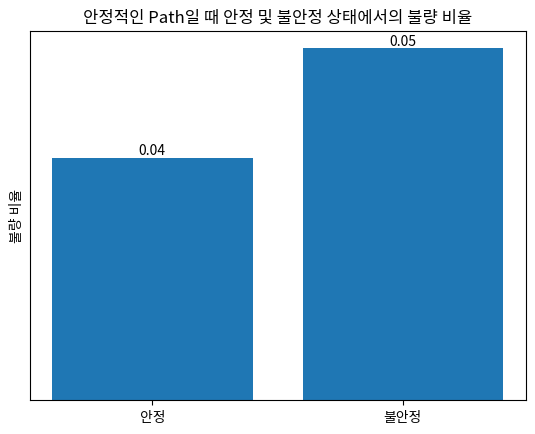

In [22]:
stability_defective_rate = 364 / (9636 + 364)
instability_defective_rate = 528 / (9472 + 528)

# 카테고리 및 불량 비율 리스트
categories = ["안정", "불안정"]
defective_rates = [stability_defective_rate, instability_defective_rate]

# 막대 그래프 그리기
bars = plt.bar(categories, defective_rates)
plt.ylabel("불량 비율")
plt.title("안정적인 Path일 때 안정 및 불안정 상태에서의 불량 비율")

# 막대 위에 숫자 표시
for bar, rate in zip(bars, defective_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, rate, f"{rate:.2f}", ha="center", va="bottom")

# y축 값 제거
plt.yticks([])
plt.show()

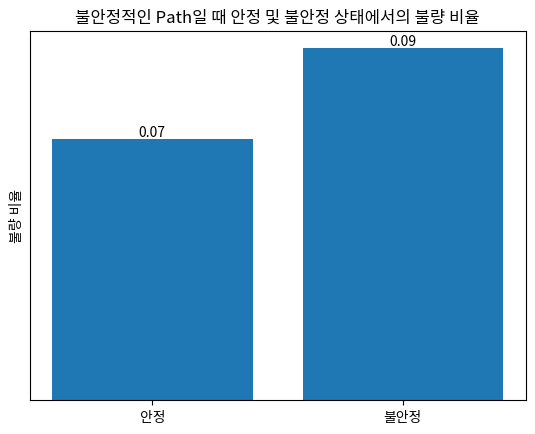

In [23]:
stability_defective_rate = 663 / (9337 + 663)
instability_defective_rate = 894 / (9106 + 894)

# 카테고리 및 불량 비율 리스트
categories = ["안정", "불안정"]
defective_rates = [stability_defective_rate, instability_defective_rate]

# 막대 그래프 그리기
bars = plt.bar(categories, defective_rates)
plt.ylabel("불량 비율")
plt.title("불안정적인 Path일 때 안정 및 불안정 상태에서의 불량 비율")

# 막대 위에 숫자 표시
for bar, rate in zip(bars, defective_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, rate, f"{rate:.2f}", ha="center", va="bottom")

# y축 값 제거
plt.yticks([])
plt.show()

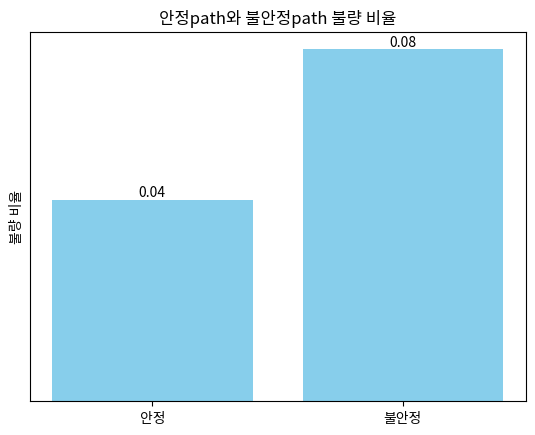

In [24]:
stability_defective_rate = (364+528) / (9636+9472+364+528)
instability_defective_rate = (663+894) / (9337+9106+663+894)

# 카테고리 및 불량 비율 리스트
categories = ["안정", "불안정"]
defective_rates = [stability_defective_rate, instability_defective_rate]

# 막대 그래프 그리기
bars = plt.bar(categories, defective_rates, color="skyblue")
plt.ylabel("불량 비율")
plt.title("안정path와 불안정path 불량 비율")

# 막대 위에 숫자 표시
for bar, rate in zip(bars, defective_rates):
    plt.text(bar.get_x() + bar.get_width() / 2, rate, f"{rate:.2f}", ha="center", va="bottom")

# y축 값 제거
plt.yticks([])
plt.show()

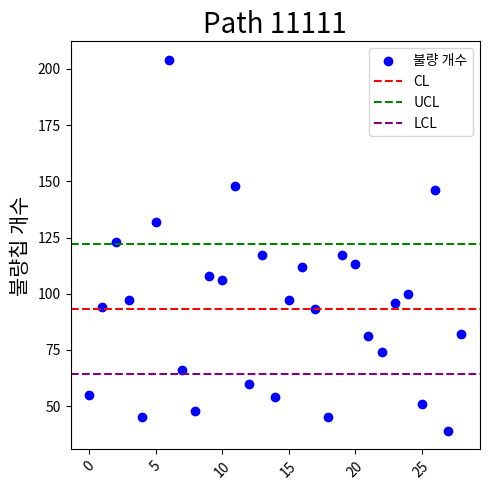

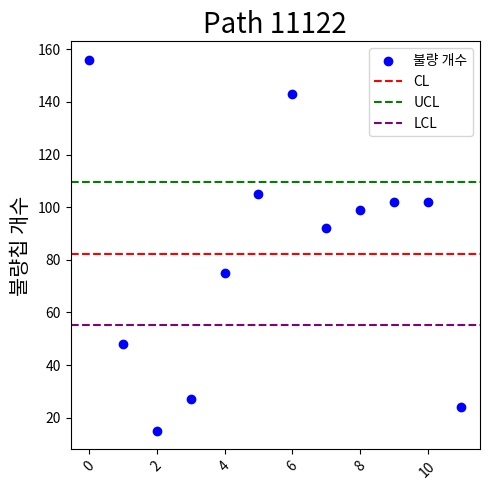

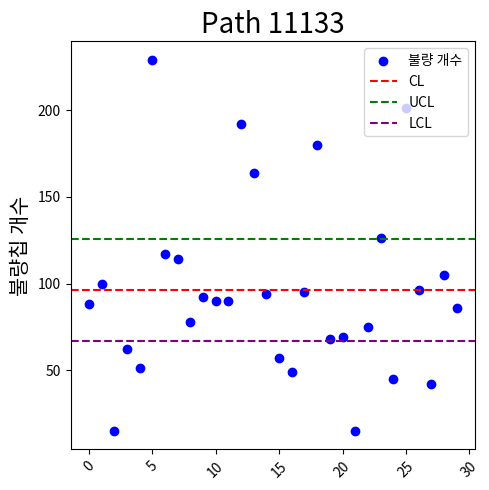

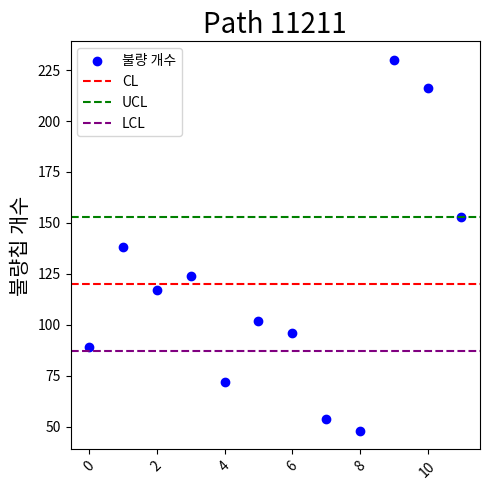

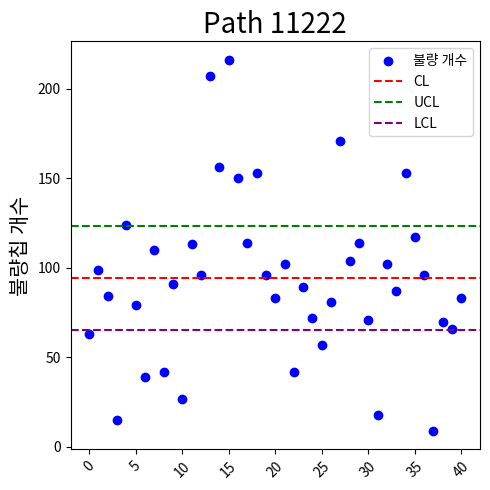

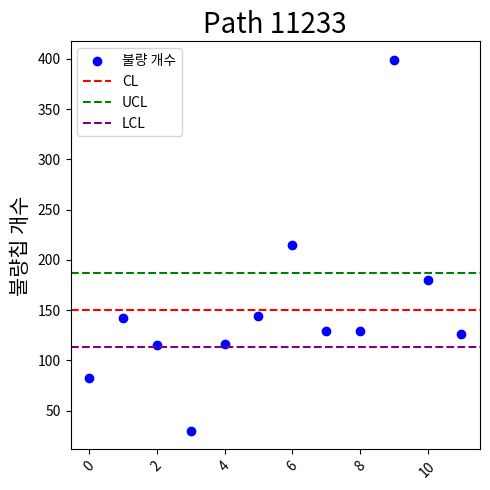

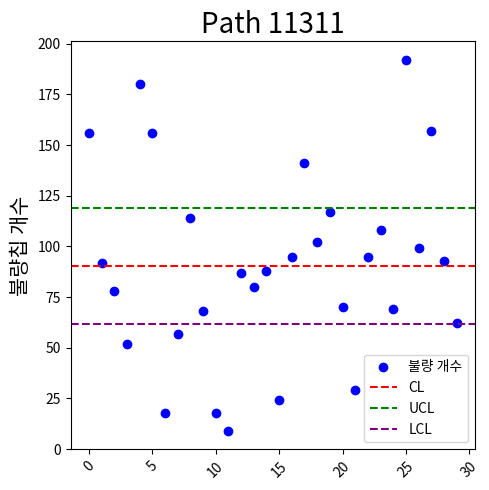

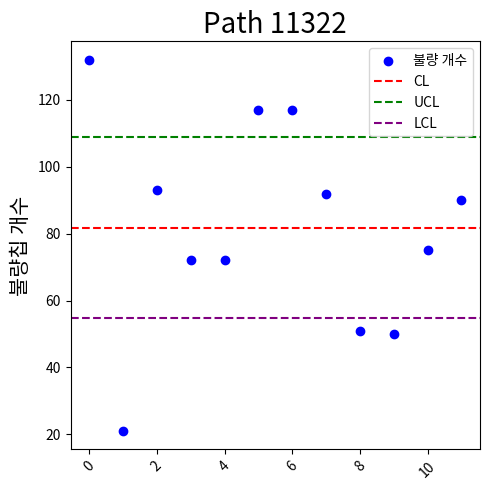

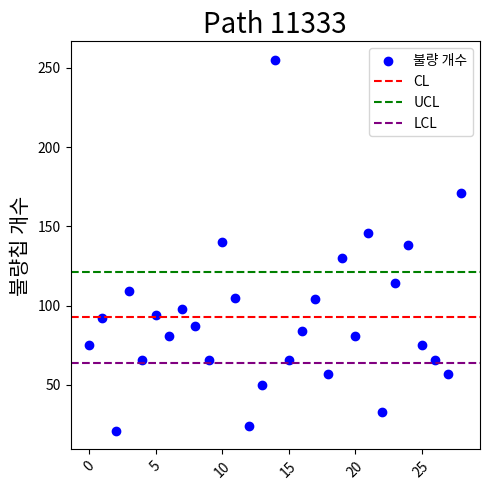

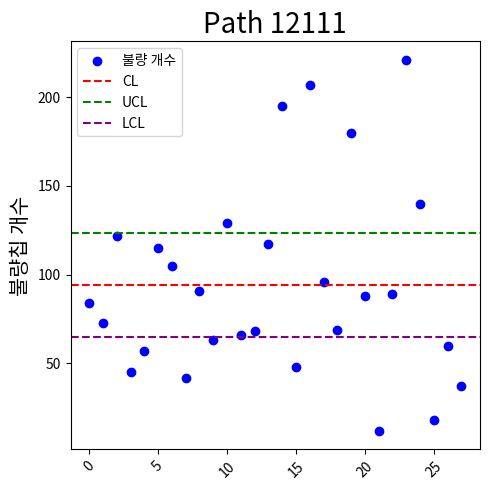

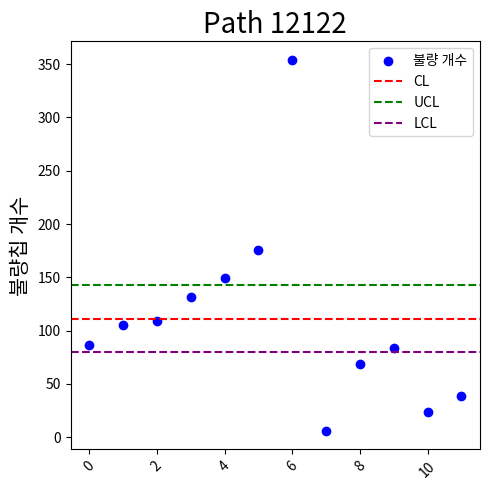

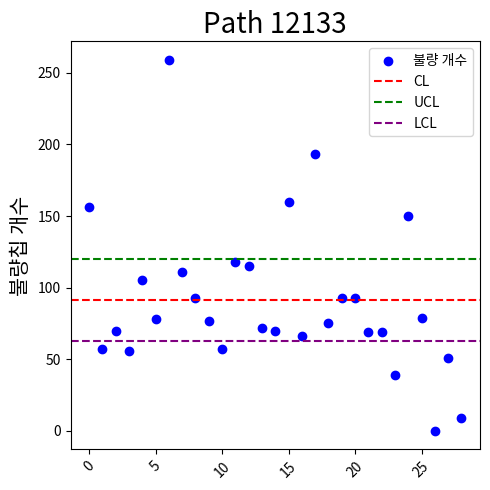

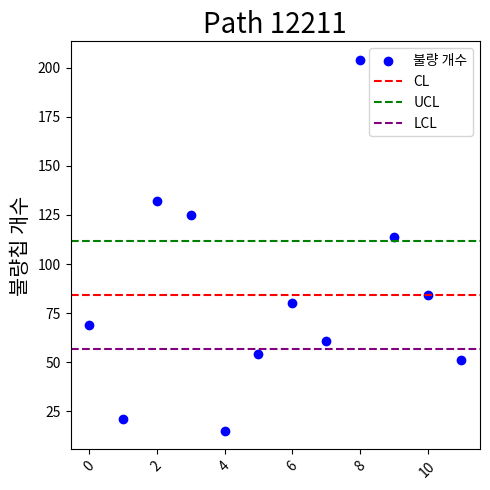

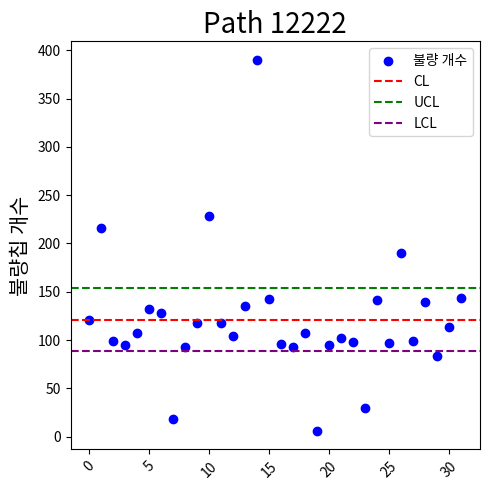

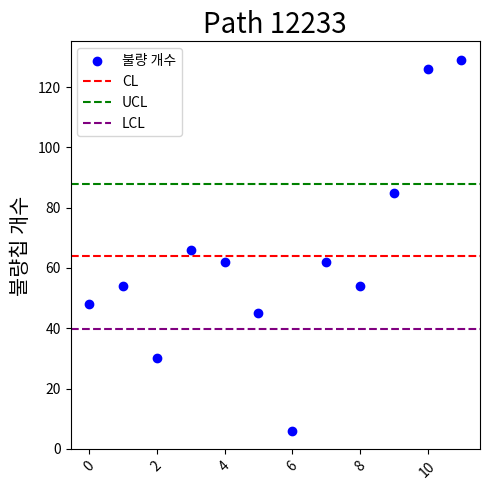

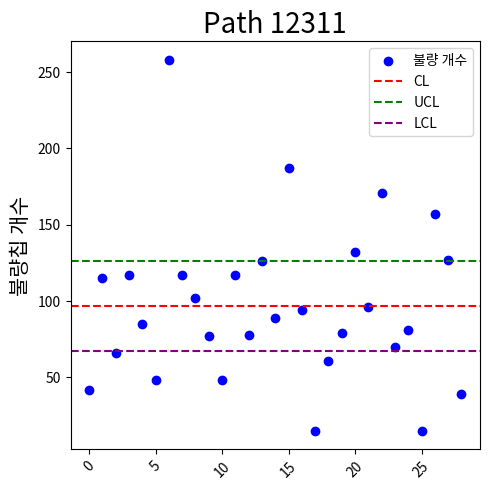

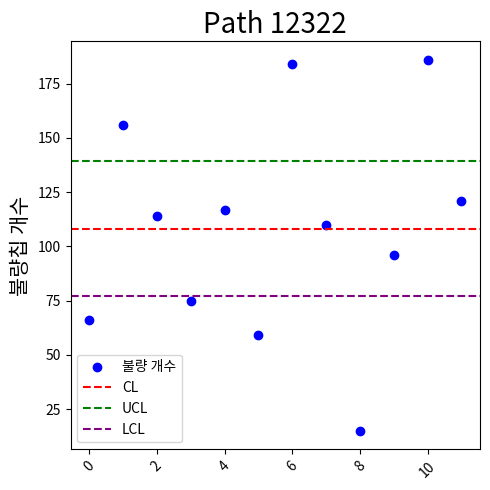

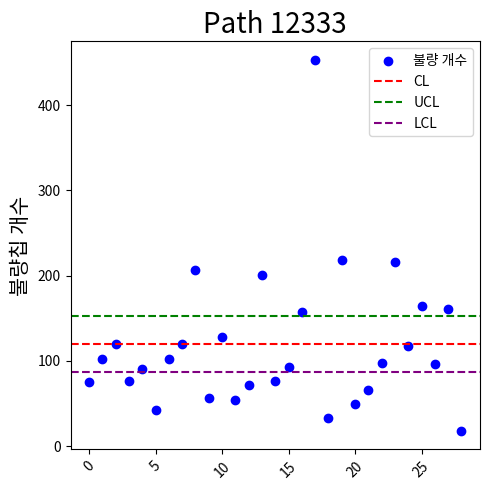

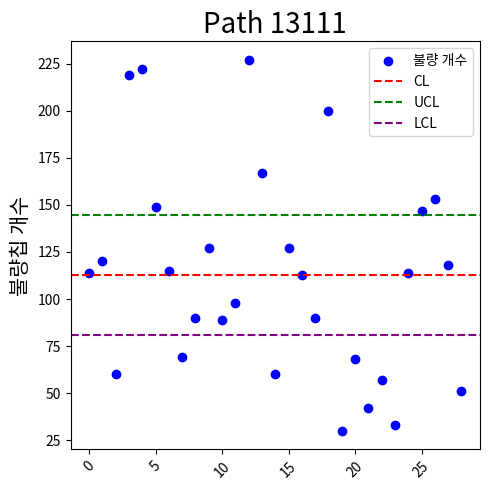

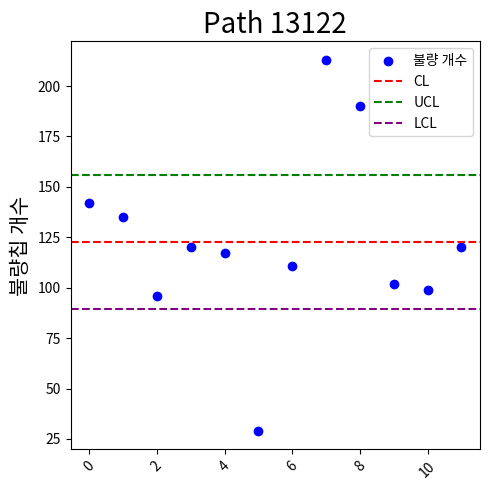

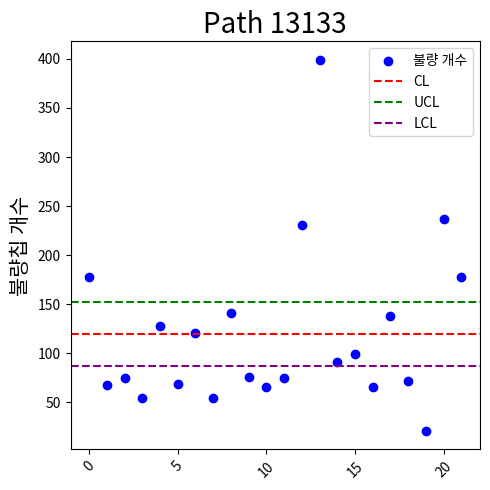

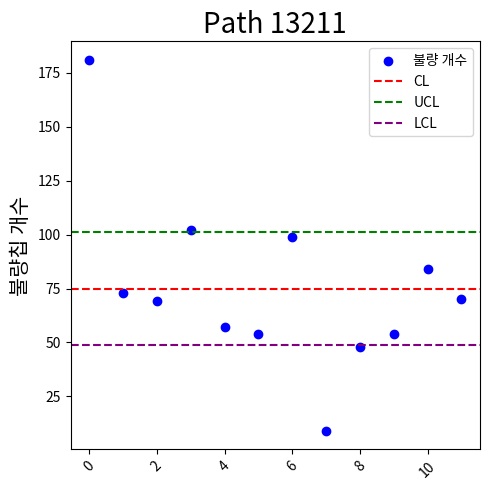

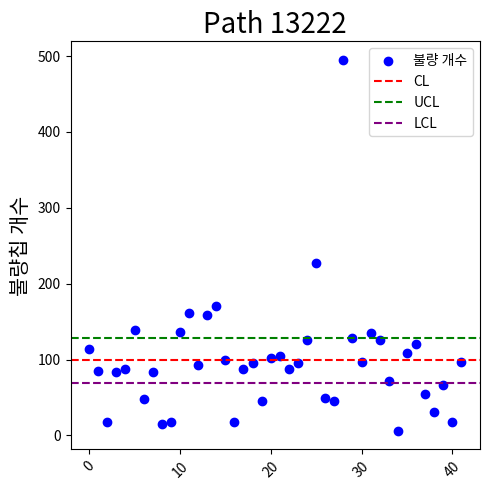

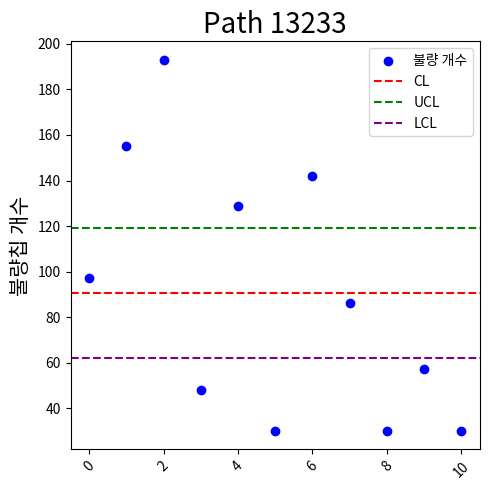

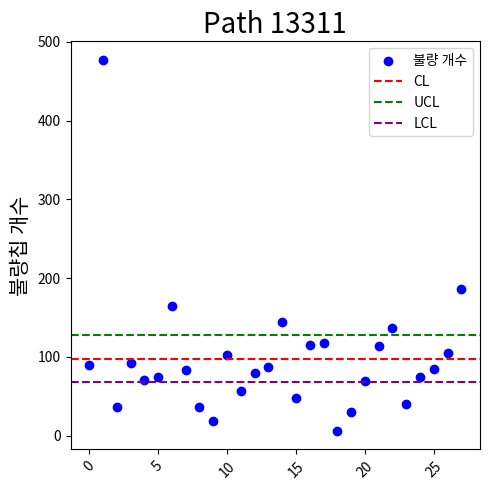

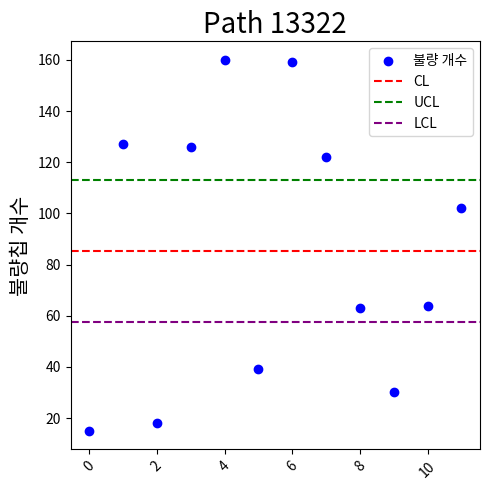

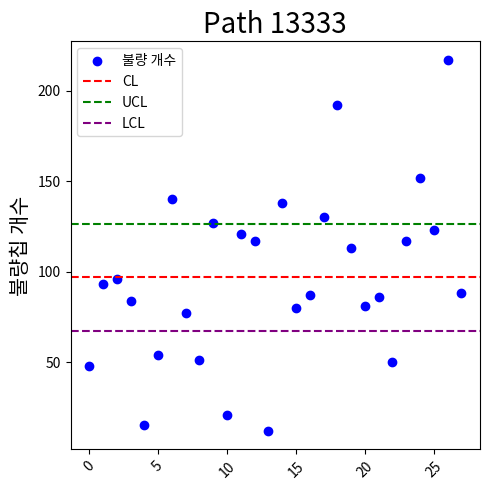

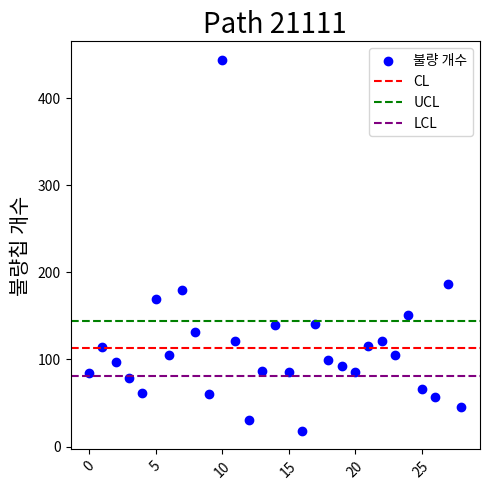

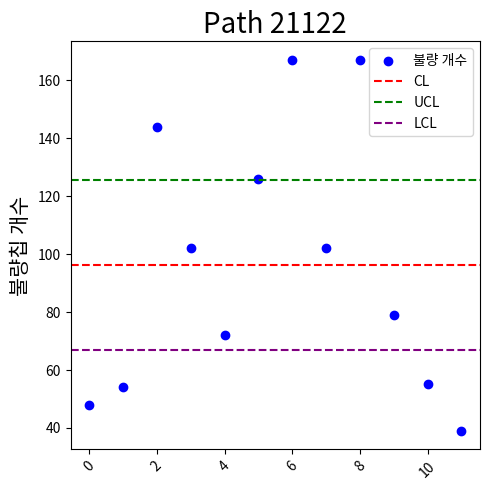

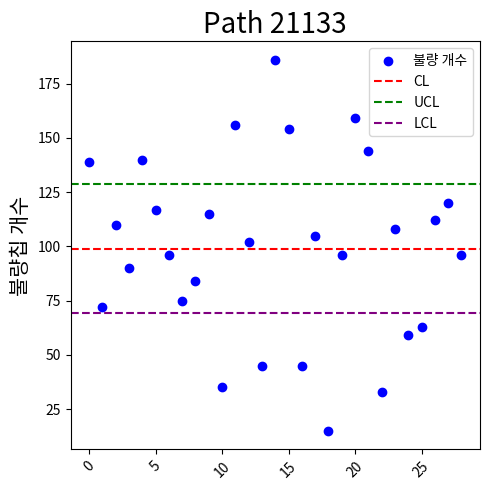

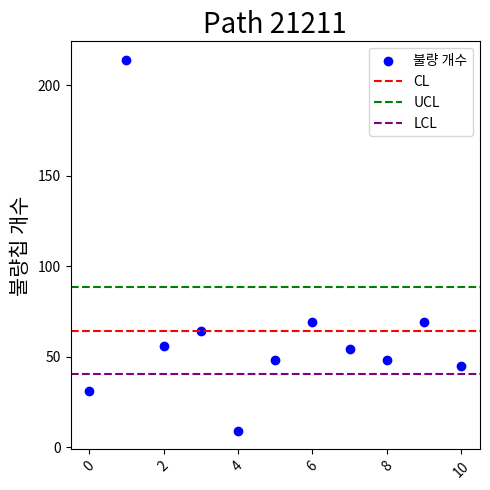

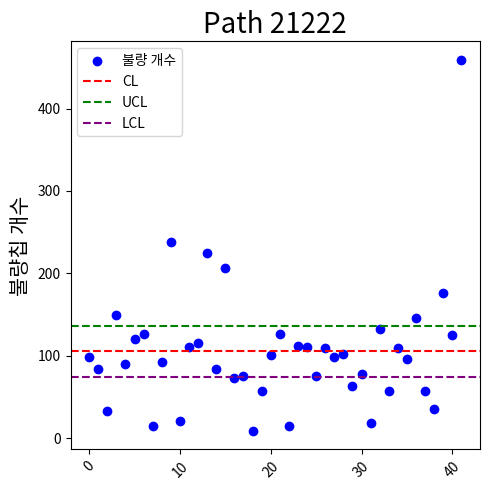

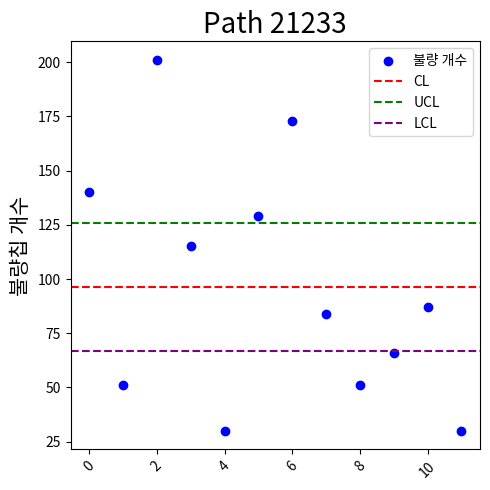

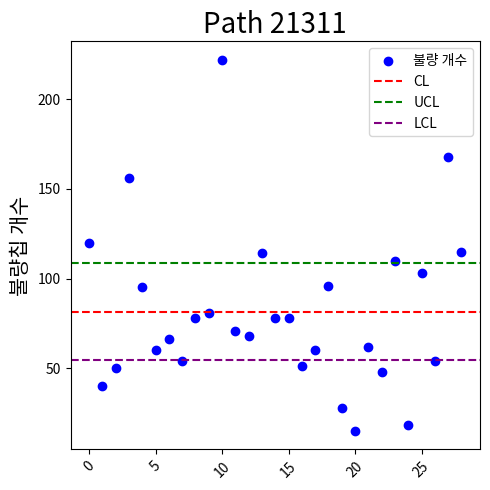

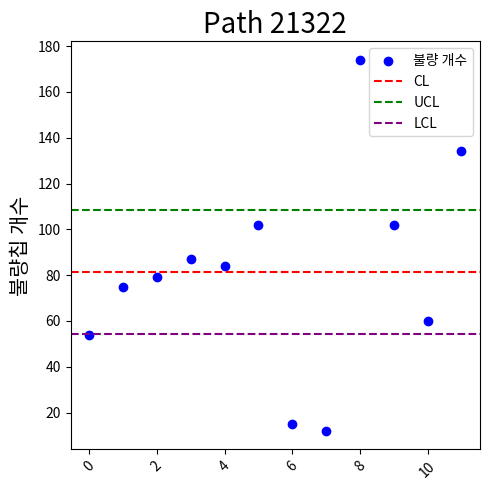

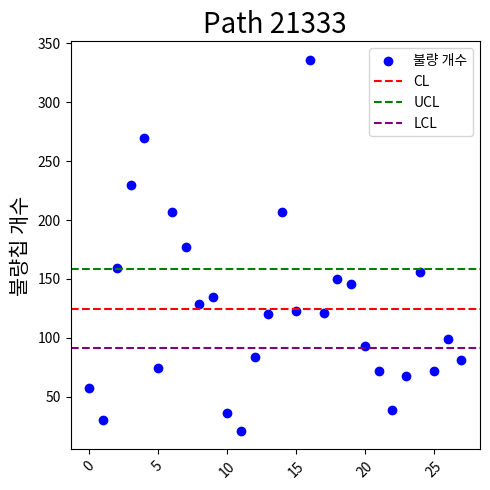

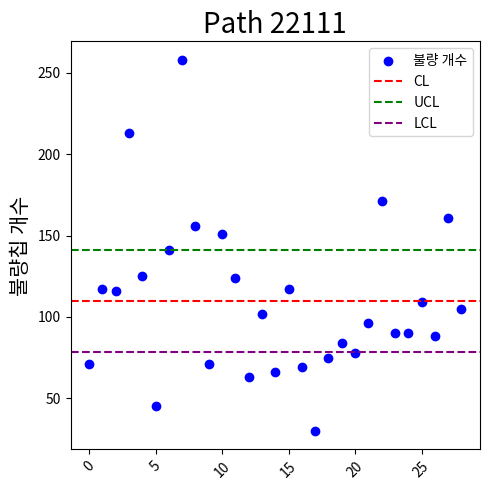

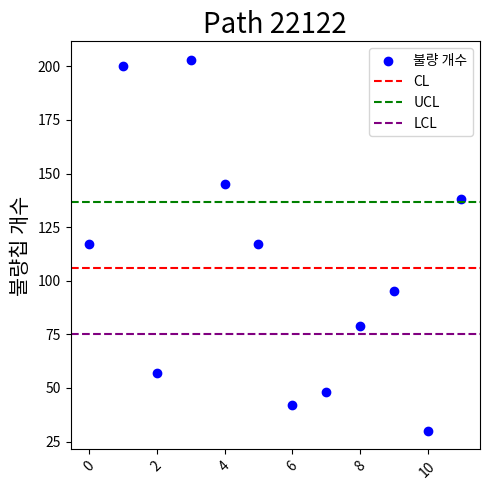

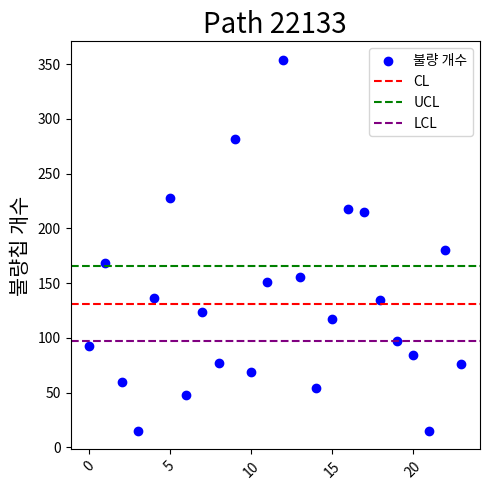

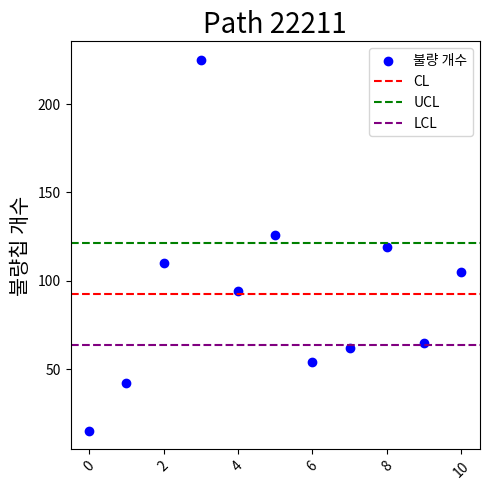

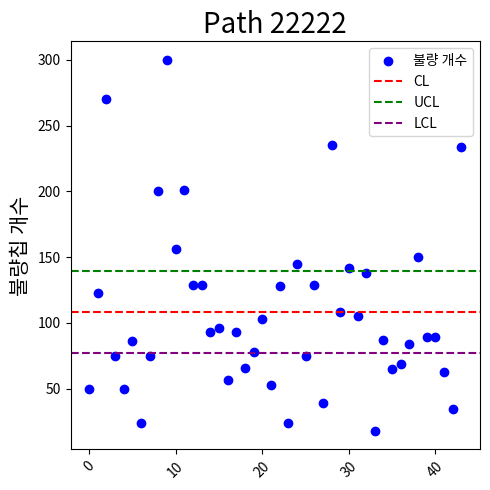

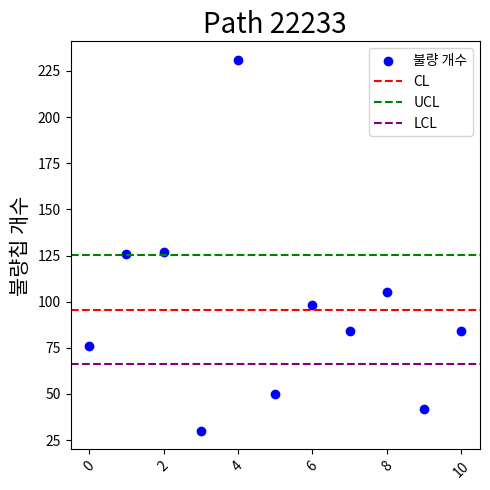

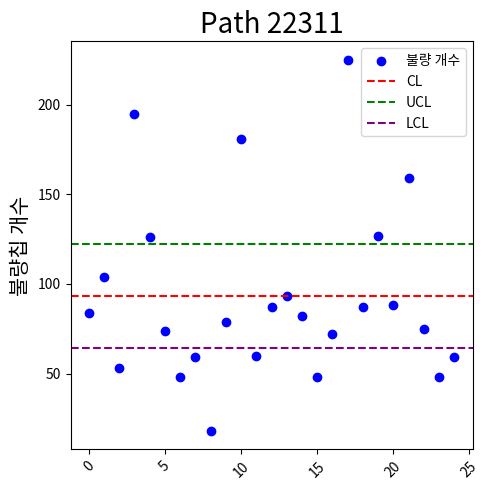

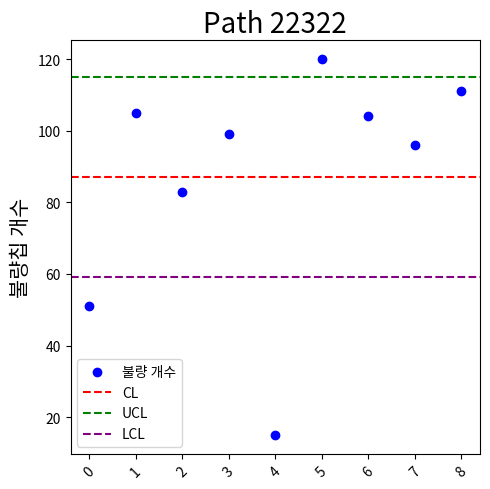

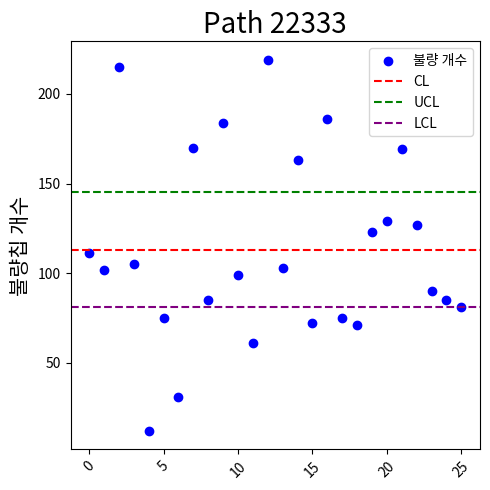

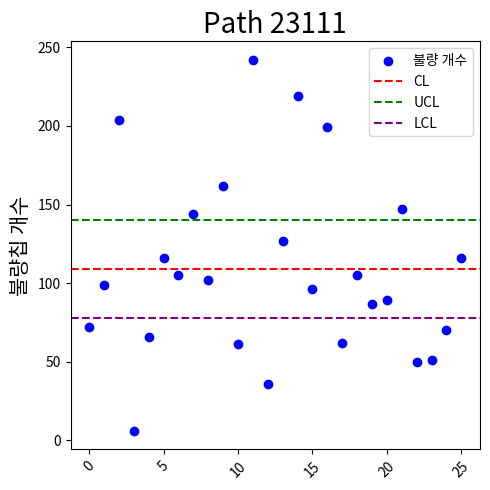

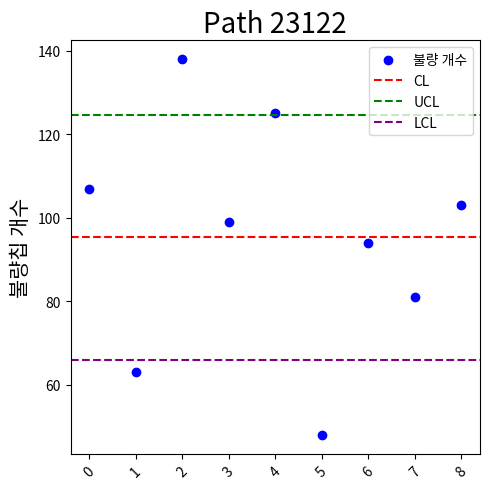

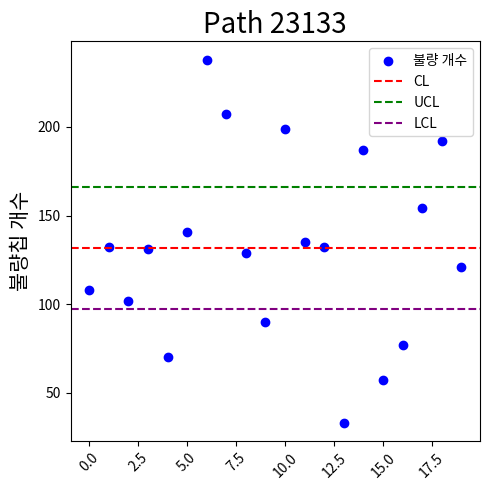

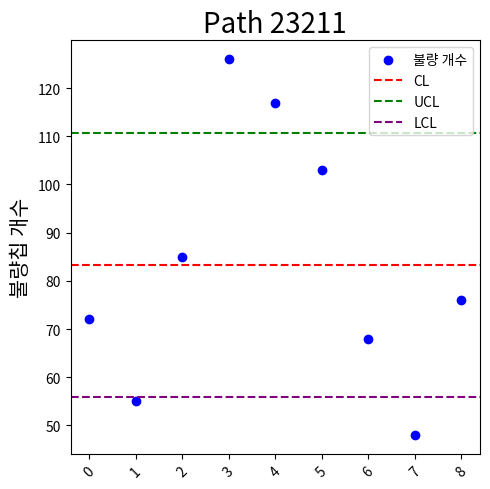

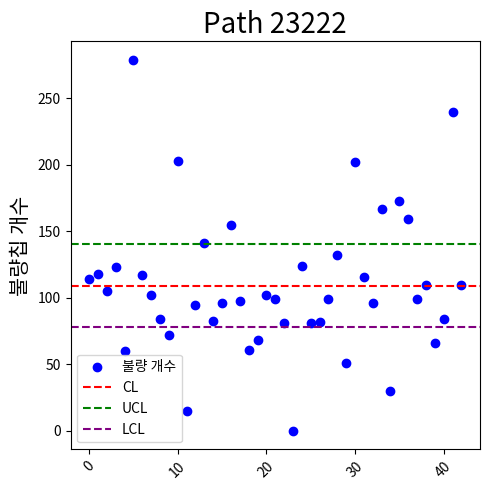

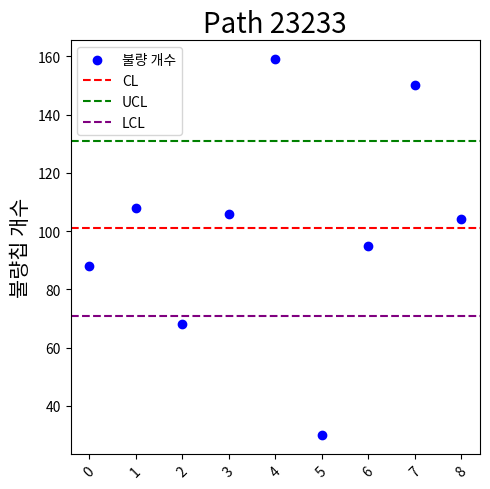

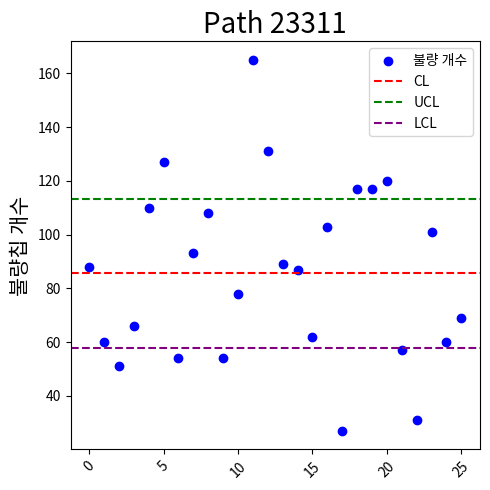

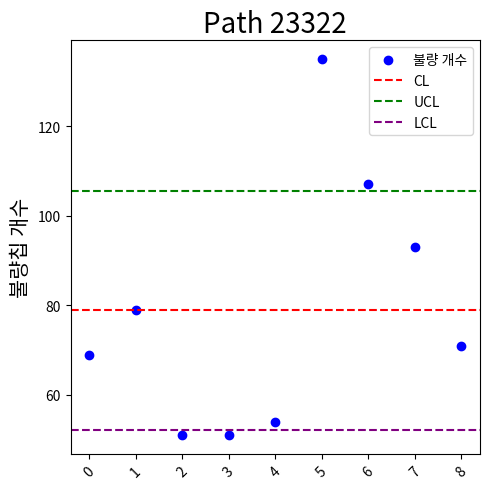

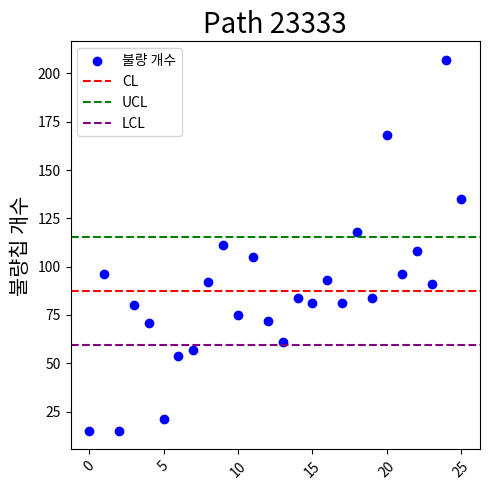

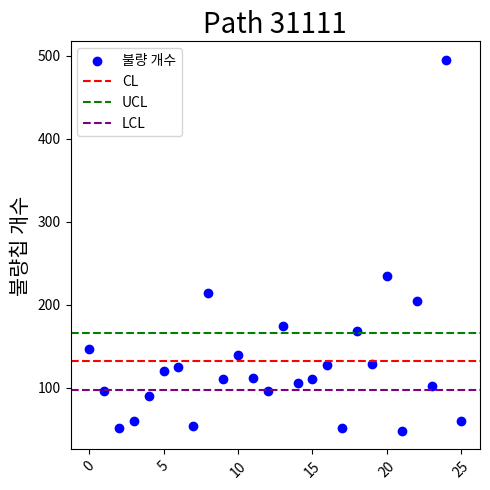

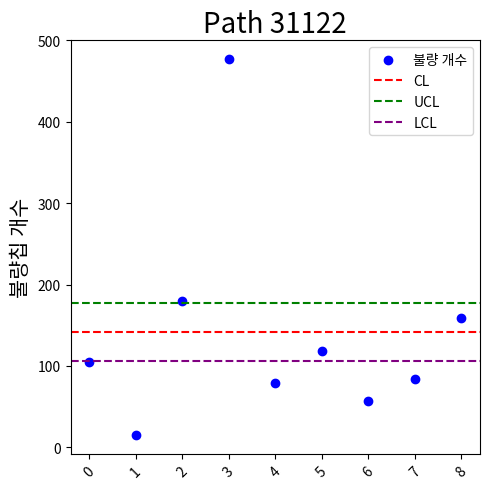

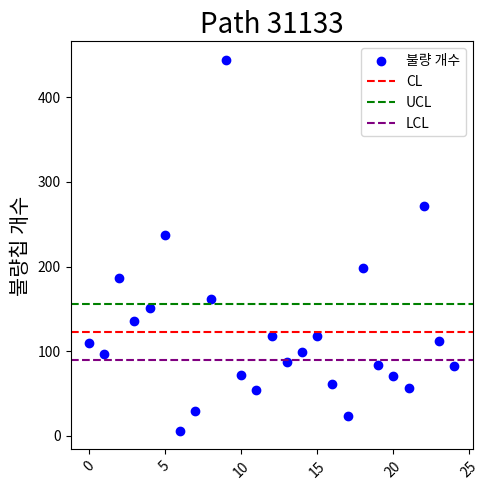

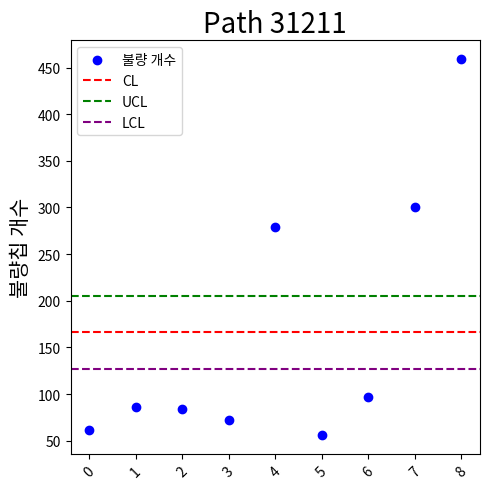

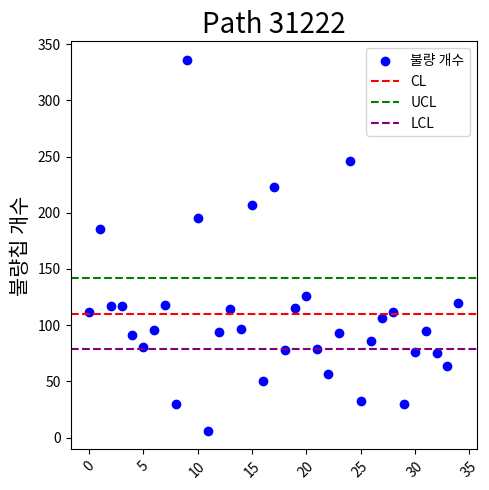

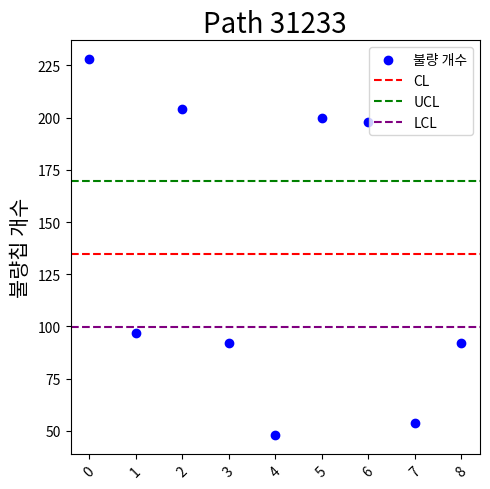

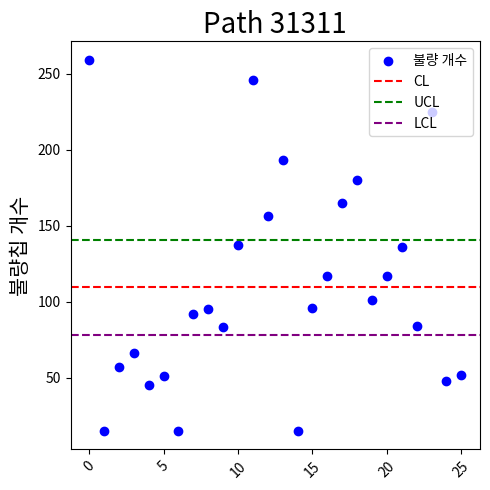

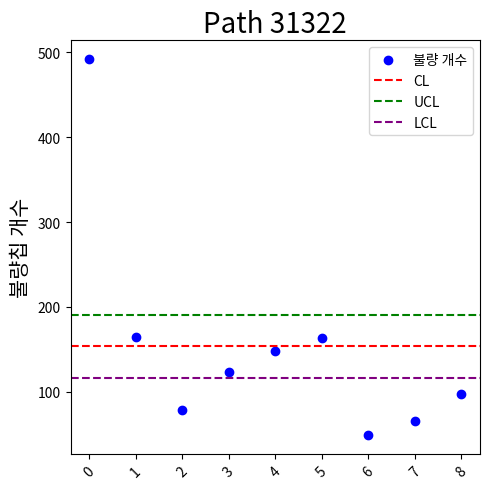

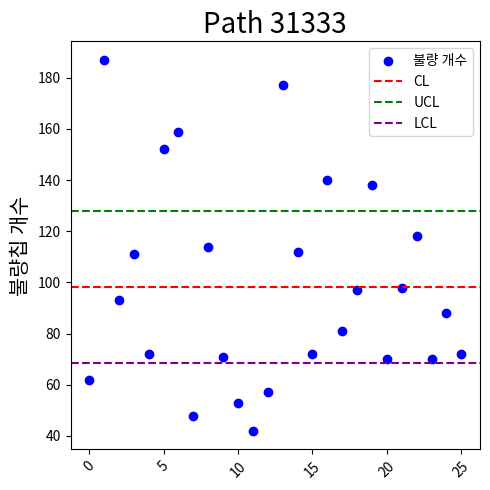

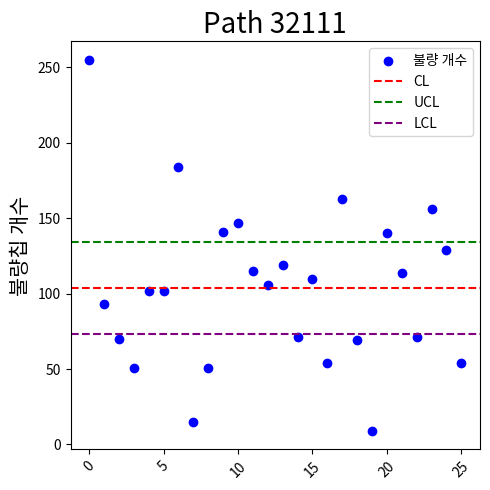

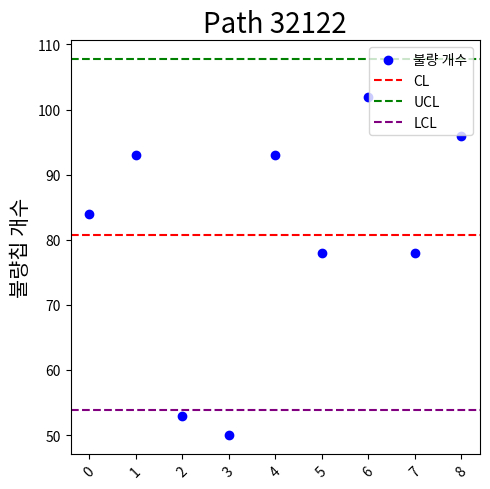

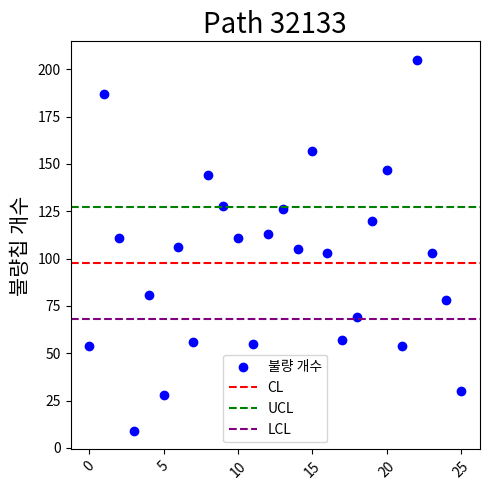

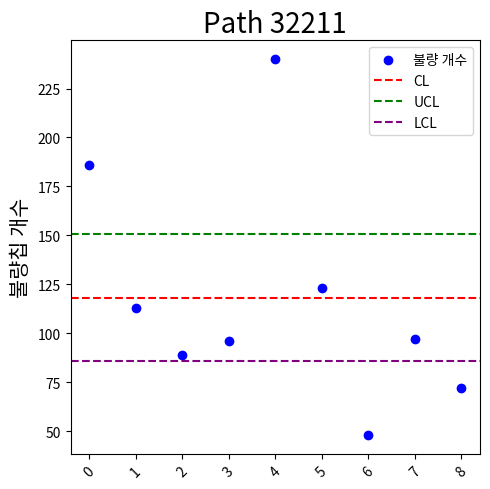

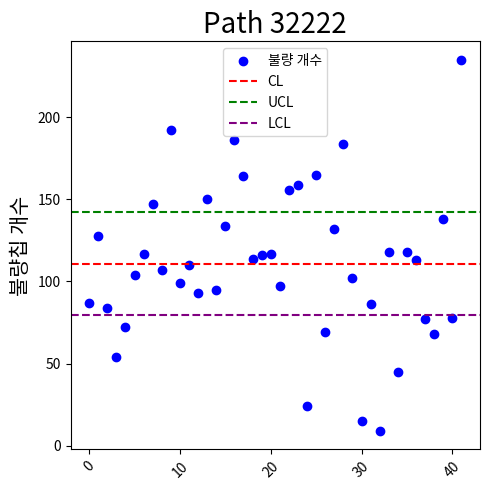

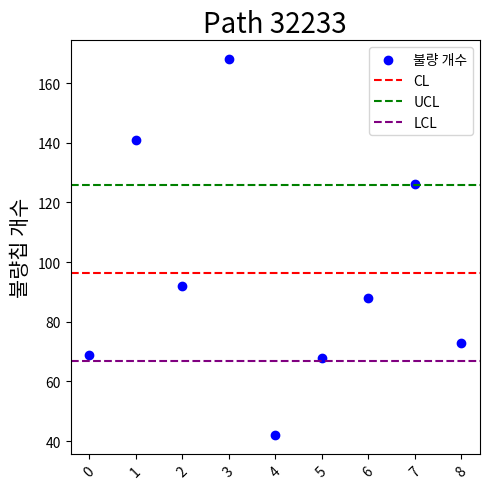

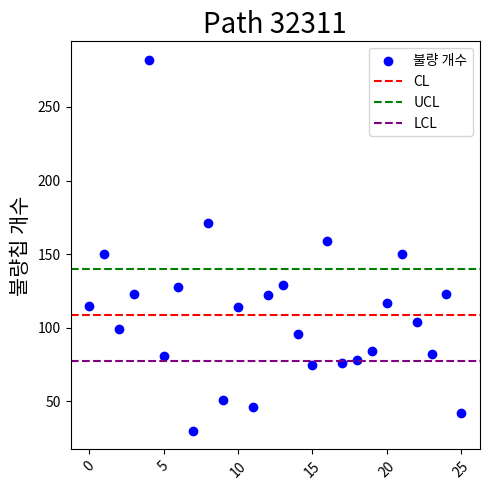

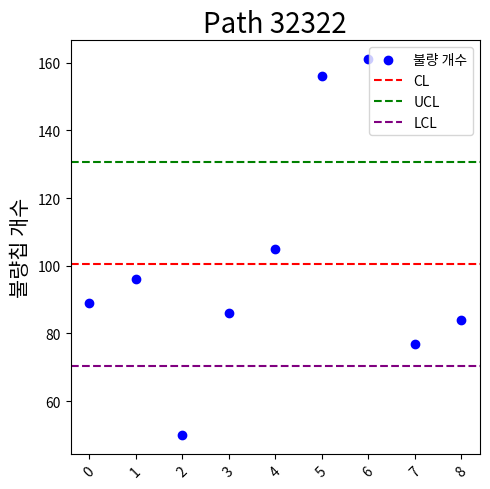

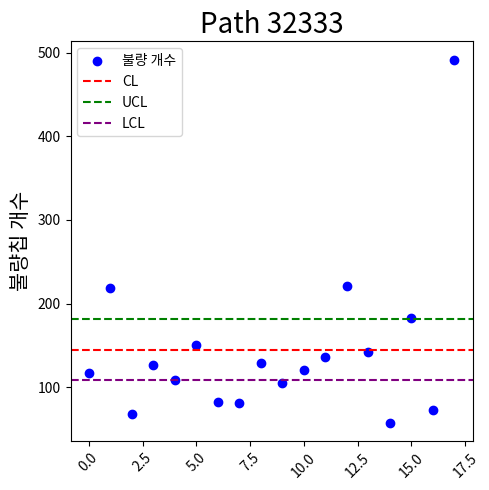

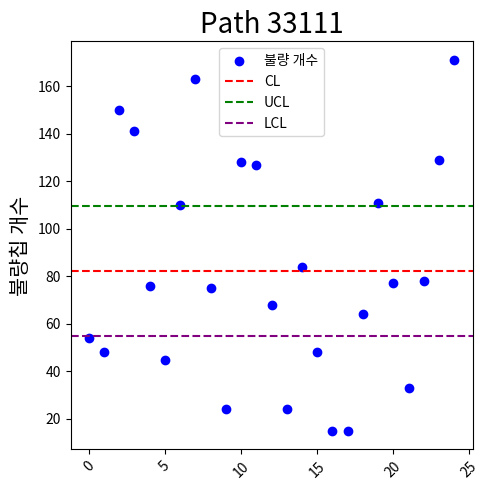

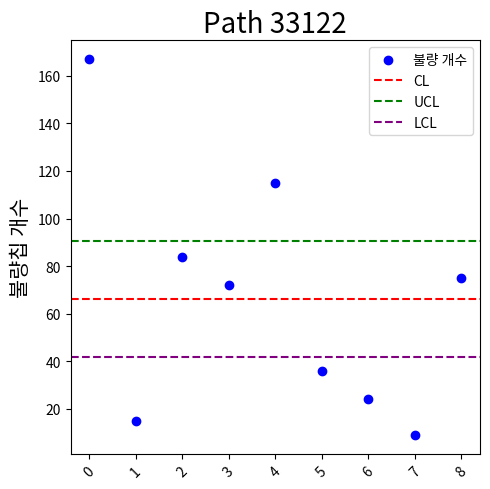

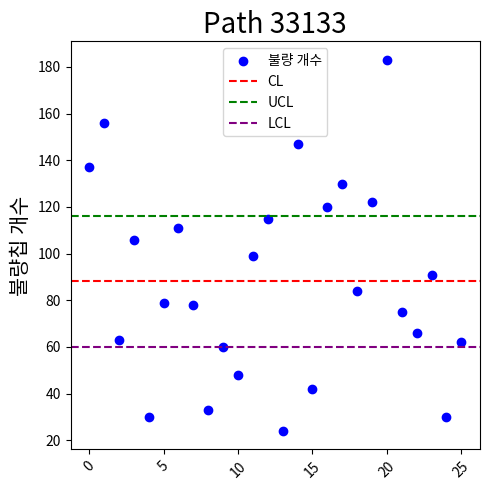

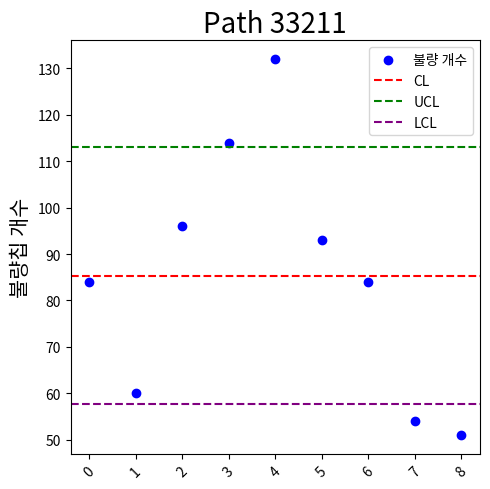

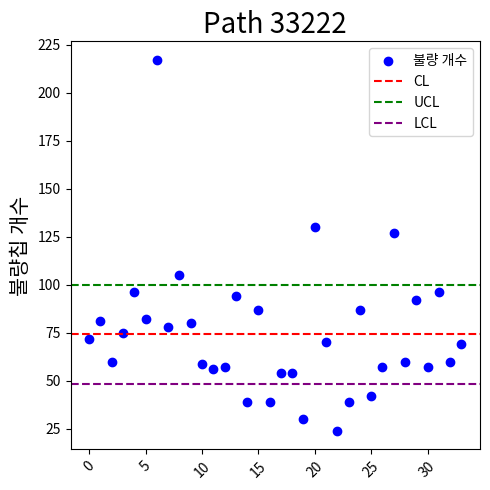

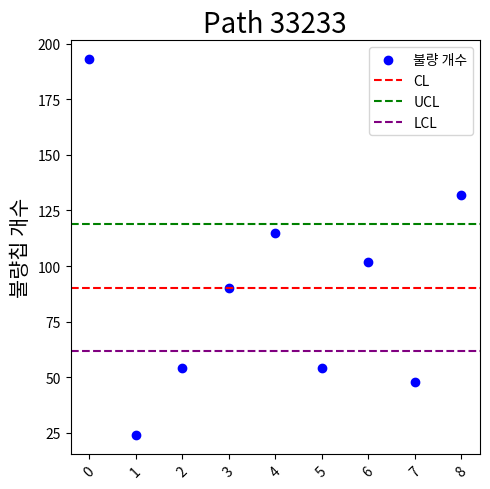

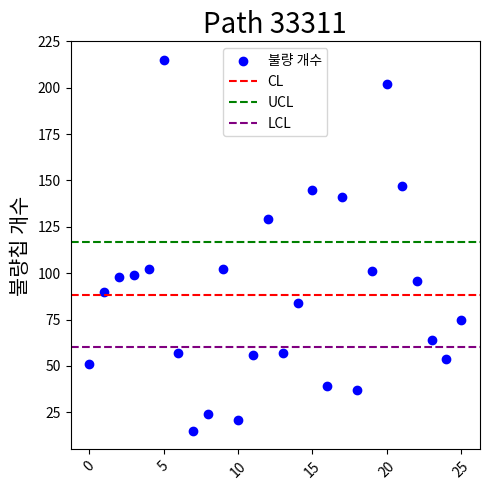

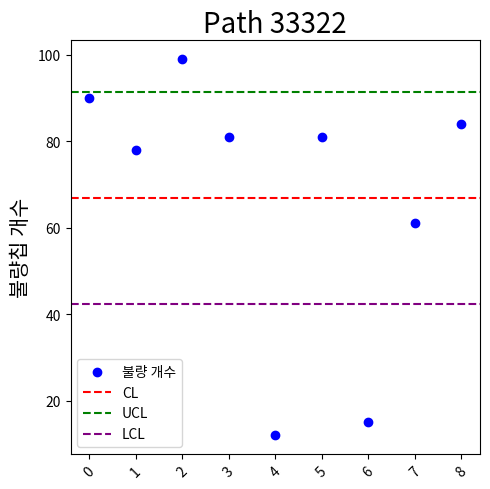

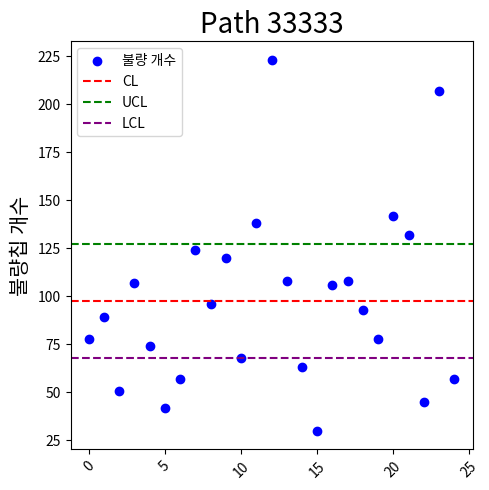

In [10]:
# Mini_Path를 기준으로 데이터 그룹화
grouped = df_raw.groupby("Path")

# Mini_Path 리스트 생성
paths = df_raw["Path"].unique()

# 큰 편차 저장 리스트
max_deviation_values = []
# 작은 편차 리스트
min_deviation_values = []
# 안정, 불안정 카운트 리스트
status_counts = []

# Mini_Path별로 차트 그리기
for path in paths:
    # group = df_raw[df_raw["Mini_Path"] == mini_path] 이거 교수님 코드
    # group.reset_index(drop = True, inplace = True) 이거 교수님 코드
    group = grouped.get_group(path)
    group.reset_index(drop = True, inplace = True)
    
    c_chart_data = group["Target"]
    timestamps = group.index
    error_data = group["Error"]

    num_data_points = len(c_chart_data)
    # if num_data_points <= 10:  # 데이터 갯수가 10 이하인 경우 처리하지 않음
    #     continue

    mean = c_chart_data.mean()
    UCL = mean + (3 * np.sqrt(mean))
    LCL = mean - (3 * np.sqrt(mean))

    # mean = c_chart_data.mean()
    # UCL = mean + (3 * np.sqrt(mean))
    # LCL = mean - (3 * np.sqrt(mean))

    deviations = np.abs(c_chart_data - mean)
    max_deviations = deviations.nlargest(5)  # 가장 큰 5개의 편차 값을 구합니다.
    # max_deviation_values.append({real_path: max_deviations.tolist()})
    max_deviation_targets = group.loc[max_deviations.index, "Target"]  # 가장 큰 편차 값의 Target을 가져옵니다.
    max_deviation_values.append({path: max_deviation_targets.tolist()})

    deviations = np.abs(c_chart_data - mean)
    min_deviations = deviations.nsmallest(5)  # 가장 큰 5개의 편차 값을 구합니다.
    # min_deviation_values.append({real_path: min_deviations.tolist()})
    min_deviation_targets = group.loc[min_deviations.index, "Target"]  # 가장 작은 편차 값의 Target을 가져옵니다.
    min_deviation_values.append({path: min_deviation_targets.tolist()})

    stability_count = 0
    instability_count = 0
    error_count = 0
    deviations_squared = (c_chart_data - mean) ** 2
    variance = deviations_squared.mean()

    for value in c_chart_data:
        if LCL <= value <= UCL:
            stability_count += 1
        else:
            instability_count += 1

    for ed in error_data:
        if ed==0:
            error_count += 1
    status_counts.append({path: {"stability": stability_count, "instability": instability_count, "defective":error_count, "variance": variance}})

    plt.figure(figsize=(5, 5))
    plt.scatter(timestamps, c_chart_data, marker='o', color='blue', label='불량 개수')  # timestamps를 그대로 사용
    plt.axhline(mean, color='red', linestyle='dashed', label='CL')
    plt.axhline(UCL, color='green', linestyle='dashed', label='UCL')
    plt.axhline(LCL, color='purple', linestyle='dashed', label='LCL')
    # plt.ylim(0, 500)
    plt.title(f"Path {int(path)}", fontsize=20)
    # plt.xlabel('날짜')
    plt.ylabel('불량칩 개수', fontsize=15)
    plt.legend()
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()

    plt.show()

In [12]:
# 데이터 리스트에서 딕셔너리 키와 값 추출
real_path = [list(item.keys())[0] for item in status_counts]
stabilities = [list(item.values())[0]['stability'] for item in status_counts]
instabilities = [list(item.values())[0]['instability'] for item in status_counts]
instabilities_rate = [list(item.values())[0]['instability']/(list(item.values())[0]['instability']+list(item.values())[0]['stability']) for item in status_counts]
defective_count = [list(item.values())[0]['defective'] for item in status_counts]
variance_count = [list(item.values())[0]['variance'] for item in status_counts]

# DataFrame 생성
status_counts_data_df = pd.DataFrame({
    'real_path': real_path,
    'stability': stabilities,
    'instability': instabilities,
    'instabilities_rate': instabilities_rate,
    'defective_count': defective_count,
    'variance': variance_count
})

status_counts_data_df.head()

,real_path,stability,instability,instabilities_rate,defective_count,variance
0,11111,16,13,0.448276,1,1368.784780
1,11122,6,6,0.500000,0,1916.388889
2,11133,16,14,0.466667,2,2648.538889
3,11211,6,6,0.500000,2,3038.243056
4,11222,24,17,0.414634,2,2154.141582


In [13]:
pd.set_option("display.max_rows", None) 
status_counts_data_df.sort_values(by="variance", inplace=True)
ddf=pd.DataFrame()
ddf["real_path"]=status_counts_data_df["real_path"]
ddf["stability"]=status_counts_data_df["stability"]
ddf["instability"]=status_counts_data_df["instability"]
ddf["variance"]=status_counts_data_df["variance"]
print(ddf)

    real_path  stability  instability      variance
64      32122          7            2    302.839506
48      23211          5            4    645.777778
75      33211          5            4    664.222222
46      23122          5            4    711.333333
52      23322          5            4    719.209877
79      33322          6            3    902.172840
7       11322          6            6    932.472222
43      22322          6            3    999.876543
51      23311         14           12   1075.321006
14      12233          8            4   1154.909722
70      32322          6            3   1166.469136
76      33222         24           10   1221.547578
50      23233          5            4   1353.654321
0       11111         16           13   1368.784780
68      32233          5            4   1460.666667
62      31333         15           11   1560.023669
21      13211          8            4   1581.500000
53      23333         17            9   1690.610947
29      2113

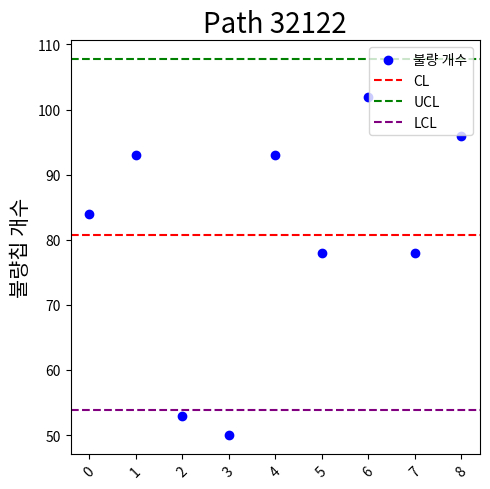

"안정 웨이퍼 수": 7, "불안정 웨이퍼 수": 2, "분산 평균": 302.8395061728395




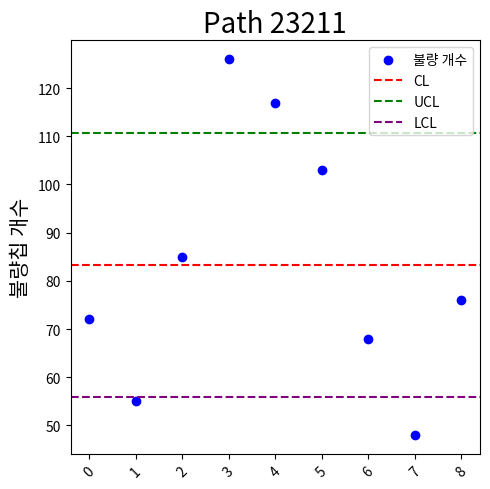

"안정 웨이퍼 수": 5, "불안정 웨이퍼 수": 4, "분산 평균": 645.7777777777778




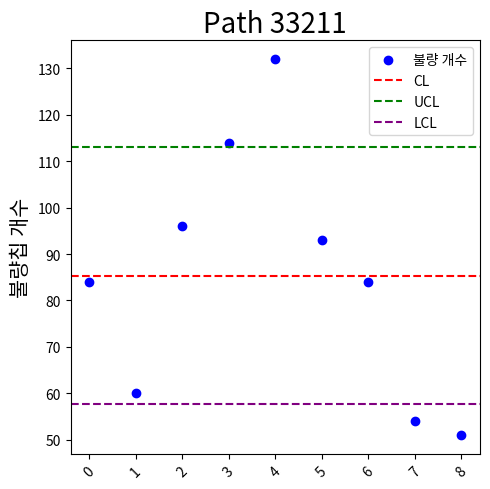

"안정 웨이퍼 수": 5, "불안정 웨이퍼 수": 4, "분산 평균": 664.2222222222222




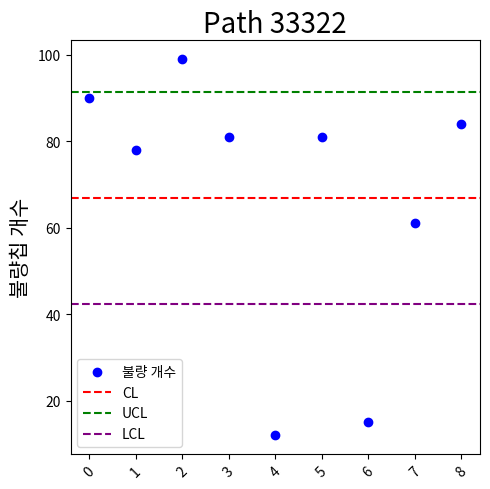

"안정 웨이퍼 수": 6, "불안정 웨이퍼 수": 3, "분산 평균": 902.1728395061729




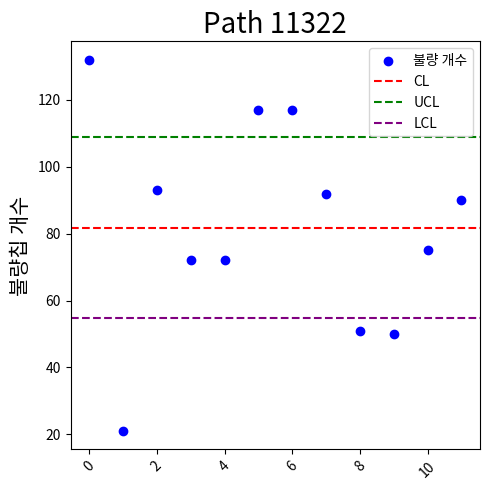

"안정 웨이퍼 수": 6, "불안정 웨이퍼 수": 6, "분산 평균": 932.4722222222223




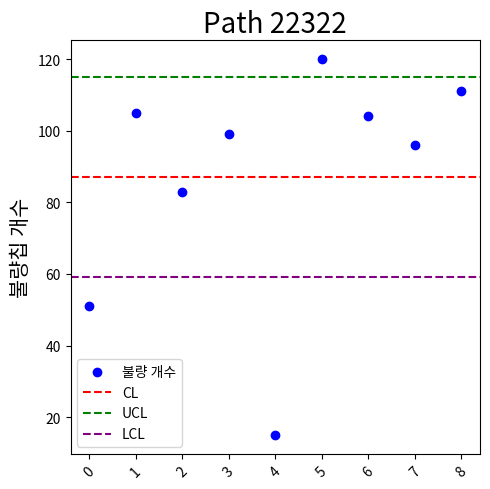

"안정 웨이퍼 수": 6, "불안정 웨이퍼 수": 3, "분산 평균": 999.8765432098766




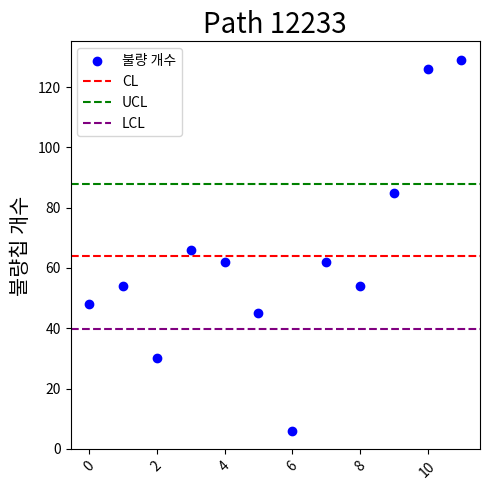

"안정 웨이퍼 수": 8, "불안정 웨이퍼 수": 4, "분산 평균": 1154.9097222222224




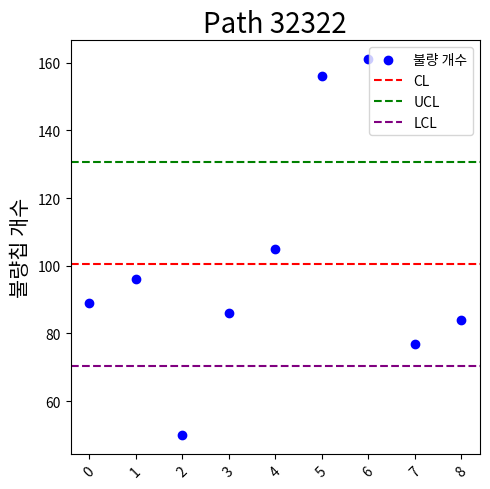

"안정 웨이퍼 수": 6, "불안정 웨이퍼 수": 3, "분산 평균": 1166.4691358024693




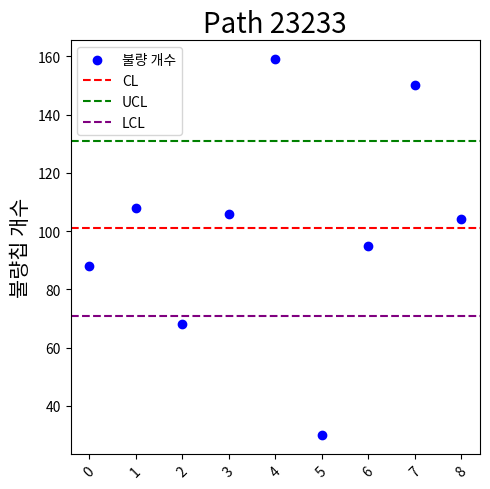

"안정 웨이퍼 수": 5, "불안정 웨이퍼 수": 4, "분산 평균": 1353.6543209876545




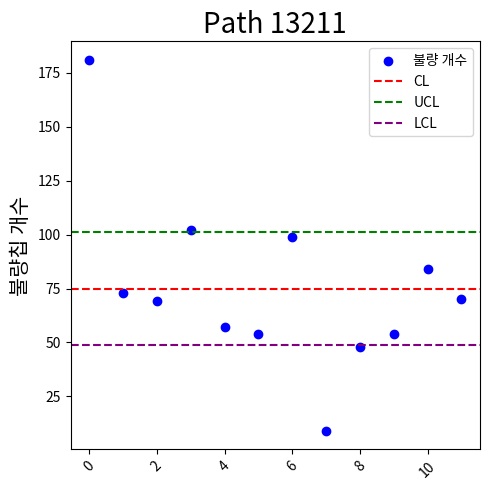

"안정 웨이퍼 수": 8, "불안정 웨이퍼 수": 4, "분산 평균": 1581.5




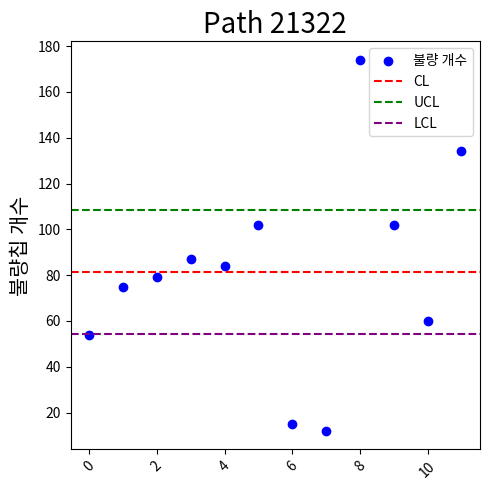

"안정 웨이퍼 수": 7, "불안정 웨이퍼 수": 5, "분산 평균": 1892.4166666666667




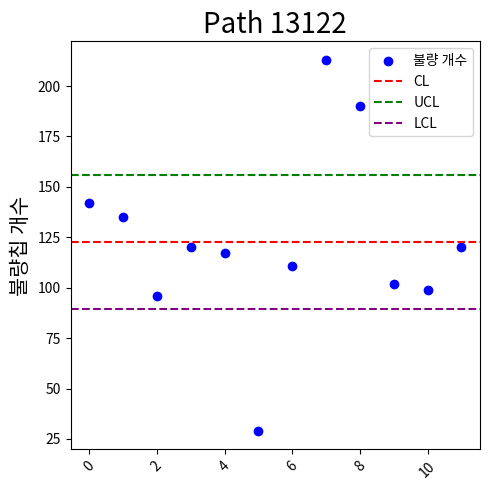

"안정 웨이퍼 수": 9, "불안정 웨이퍼 수": 3, "분산 평균": 1989.4722222222224




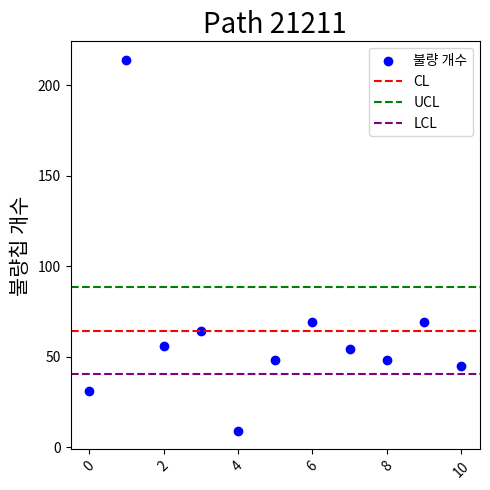

"안정 웨이퍼 수": 8, "불안정 웨이퍼 수": 3, "분산 평균": 2518.1983471074386




In [20]:
# Mini_Path를 기준으로 데이터 그룹화
grouped = df_raw.groupby("Path")

# Mini_Path 리스트 생성
paths = df_raw["Path"].unique()

# 큰 편차 저장 리스트
max_deviation_values = []
# 작은 편차 리스트
min_deviation_values = []
# 안정, 불안정 카운트 리스트
status_counts = []

# Mini_Path별로 차트 그리기
for path in [32122,23211,33211,33322,11322,22322,12233,32322,23233,13211,21322,13122,21211]:
    # group = df_raw[df_raw["Mini_Path"] == mini_path] 이거 교수님 코드
    # group.reset_index(drop = True, inplace = True) 이거 교수님 코드
    group = grouped.get_group(path)
    group.reset_index(drop = True, inplace = True)
    
    c_chart_data = group["Target"]
    timestamps = group.index
    error_data = group["Error"]

    num_data_points = len(c_chart_data)
    # if num_data_points <= 10:  # 데이터 갯수가 10 이하인 경우 처리하지 않음
    #     continue

    mean = c_chart_data.mean()
    UCL = mean + (3 * np.sqrt(mean))
    LCL = mean - (3 * np.sqrt(mean))

    # mean = c_chart_data.mean()
    # UCL = mean + (3 * np.sqrt(mean))
    # LCL = mean - (3 * np.sqrt(mean))

    deviations = np.abs(c_chart_data - mean)
    max_deviations = deviations.nlargest(5)  # 가장 큰 5개의 편차 값을 구합니다.
    # max_deviation_values.append({real_path: max_deviations.tolist()})
    max_deviation_targets = group.loc[max_deviations.index, "Target"]  # 가장 큰 편차 값의 Target을 가져옵니다.
    max_deviation_values.append({path: max_deviation_targets.tolist()})

    deviations = np.abs(c_chart_data - mean)
    min_deviations = deviations.nsmallest(5)  # 가장 큰 5개의 편차 값을 구합니다.
    # min_deviation_values.append({real_path: min_deviations.tolist()})
    min_deviation_targets = group.loc[min_deviations.index, "Target"]  # 가장 작은 편차 값의 Target을 가져옵니다.
    min_deviation_values.append({path: min_deviation_targets.tolist()})

    stability_count = 0
    instability_count = 0
    error_count = 0
    deviations_squared = (c_chart_data - mean) ** 2
    variance = deviations_squared.mean()

    for value in c_chart_data:
        if LCL <= value <= UCL:
            stability_count += 1
        else:
            instability_count += 1

    for ed in error_data:
        if ed==0:
            error_count += 1
    status_counts.append({path: {"stability": stability_count, "instability": instability_count, "defective":error_count, "variance": variance}})

    plt.figure(figsize=(5, 5))
    plt.scatter(timestamps, c_chart_data, marker='o', color='blue', label='불량 개수')  # timestamps를 그대로 사용
    plt.axhline(mean, color='red', linestyle='dashed', label='CL')
    plt.axhline(UCL, color='green', linestyle='dashed', label='UCL')
    plt.axhline(LCL, color='purple', linestyle='dashed', label='LCL')
    # plt.ylim(0, 500)
    plt.title(f"Path {int(path)}", fontsize=20)
    # plt.xlabel('날짜')
    plt.ylabel('불량칩 개수', fontsize=15)
    plt.legend()
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.tight_layout()

    plt.show()
    print(f'"안정 웨이퍼 수": {stability_count}, "불안정 웨이퍼 수": {instability_count}, "분산 평균": {variance}\n\n')